Phase 1. Initial Data wrangling to build features, test important features, and get a sense of the dataset. 

In [ ]:
# Libraries Imports
import os
import re
import warnings
from pathlib import Path

# Data science and numerical computing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scientific computing
from scipy.signal import correlate
from scipy.stats import binomtest, chi2_contingency, kurtosis, linregress, t, ttest_ind

# Machine learning - core
from sklearn.base import clone
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import partial_dependence, permutation_importance
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    adjusted_rand_score, average_precision_score, brier_score_loss, 
    confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error,
    r2_score, roc_auc_score, silhouette_score, silhouette_samples
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

# Imbalanced learning
from imblearn.over_sampling import SMOTE

# Statistical analysis
from statsmodels.stats.multitest import multipletests

# Set visualization style
sns.set_theme(context="talk", style="white")
plt.rcParams.update({
    "axes.spines.top": False, 
    "axes.spines.right": False,
    "figure.dpi": 120, 
    "savefig.dpi": 300, 
    "axes.grid": True, 
    "grid.alpha": 0.12
})


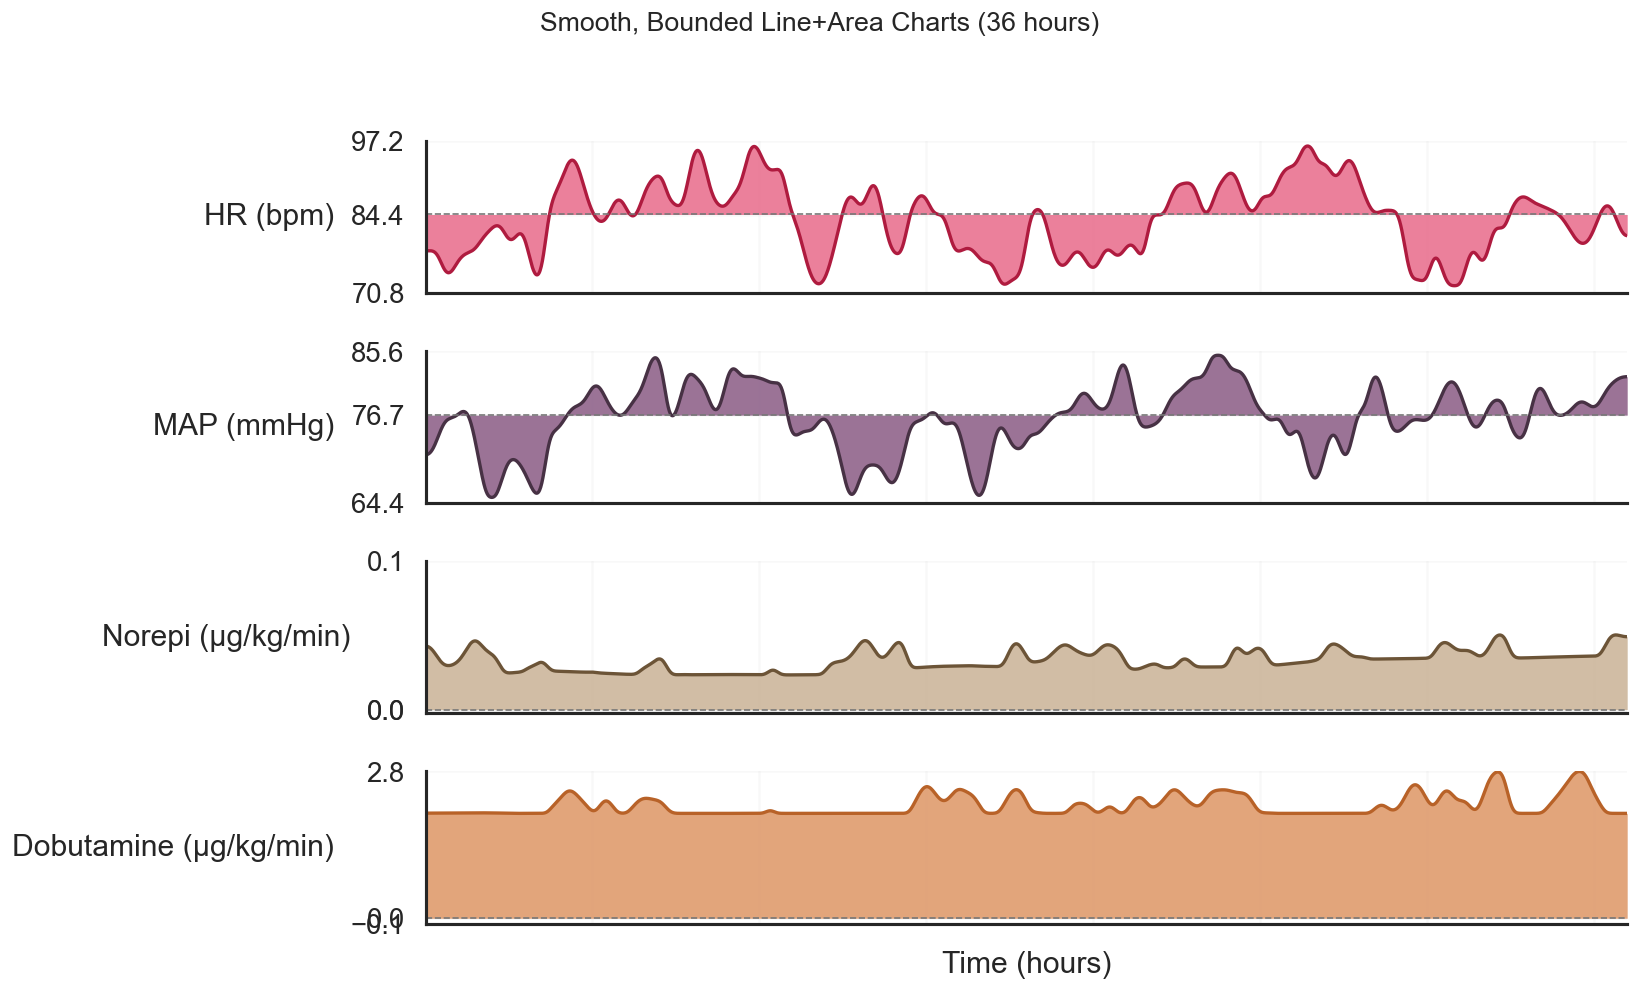

In [ ]:
# Figure Generation for Schema in Figure 1

# ---------- Smooth random generators (no sinusoids) ----------
def _gauss_kernel(sigma):
    r = max(1, int(round(3*sigma)))
    x = np.arange(-r, r+1, dtype=float)
    k = np.exp(-0.5*(x/sigma)**2); k /= k.sum()
    return k

def _smooth(y, median_win=21, gauss_sigma=6):
    y = pd.Series(y, dtype=float)
    y = y.rolling(window=median_win, center=True, min_periods=1).median().to_numpy()
    k = _gauss_kernel(gauss_sigma)
    pad = len(k)//2
    ypad = np.pad(y, pad, mode="reflect")
    y = np.convolve(ypad, k, mode="same")[pad:-pad]
    return y

def _colored_noise(n, sigma=10, amp=1.0, seed=None):
    rng = np.random.default_rng(seed)
    k = _gauss_kernel(sigma)
    z = rng.standard_normal(n)
    y = np.convolve(z, k, mode="same")
    y /= (np.nanmax(np.abs(y)) + 1e-12)
    return amp * y

def _random_walk(n, step_sigma=0.12, smooth_sigma=24, amp=1.0, seed=None):
    rng = np.random.default_rng(seed)
    r = rng.normal(0, step_sigma, n)
    y = np.cumsum(r)
    y = _smooth(y, median_win=1, gauss_sigma=smooth_sigma)
    y /= (np.nanmax(np.abs(y)) + 1e-12)
    return amp * y

def _pulses(n, n_min=3, n_max=7, width=18, amp=1.0, seed=None):
    rng = np.random.default_rng(seed)
    impulses = np.zeros(n)
    for _ in range(rng.integers(n_min, n_max+1)):
        pos = rng.integers(0, n)
        impulses[pos] = rng.uniform(0.5, 1.0) * amp
    return _smooth(impulses, median_win=1, gauss_sigma=width)

def stitched_random(n, segments=10, amp=1.0, seed=0):
    """Piecewise regimes with crossfades → more variation over long timelines."""
    rng = np.random.default_rng(seed)
    seg_len = n // segments
    out = np.zeros(n)
    for s in range(segments):
        start, end = s*seg_len, (s+1)*seg_len if s < segments-1 else n
        length = end - start
        seg = (_colored_noise(length, sigma=rng.integers(8, 14), amp=0.7*amp, seed=rng.integers(1e9))
               + _random_walk(length, step_sigma=0.10, smooth_sigma=28, amp=0.6*amp, seed=rng.integers(1e9))
               + _pulses(length, n_min=2, n_max=5, width=rng.integers(12, 20), amp=0.9*amp, seed=rng.integers(1e9)))
        seg = _smooth(seg, median_win=9, gauss_sigma=5)
        if s == 0:
            out[start:end] = seg
        else:
            fade = min(60, length//5)
            w = np.linspace(0, 1, fade)
            out[start:start+fade] = out[start:start+fade]*(1-w) + seg[:fade]*w
            out[start+fade:end] = seg[fade:]
    return _smooth(out, median_win=11, gauss_sigma=6)

# ---------- Build LONG, smooth, bounded mock data ----------
HOURS, FREQ_MIN, SEGMENTS = 36, 1, 10
N = HOURS * 60 // FREQ_MIN
time_hr = np.arange(N) * (FREQ_MIN / 60.0)

rng = np.random.default_rng(2025)

# Physiologic hard bounds (final clamp)
RANGE = {
    "HR":   (50, 130),     # bpm
    "MAP":  (45, 110),     # mmHg
    "NEPI": (0.0, 0.20),   # μg/kg/min
    "DOBU": (0.0, 10.0),   # μg/kg/min
}

def make_vital(n, baseline, amp, prange, seed):
    raw = stitched_random(n, segments=SEGMENTS, amp=1.0, seed=seed)
    y = baseline + amp * raw
    # Winsorize → clamp to 1st–99th pct within range window, then hard-clip to physiologic bounds
    lo, hi = np.percentile(y, [1, 99])
    lo = max(lo, prange[0]); hi = min(hi, prange[1])
    y = np.clip(y, lo, hi)
    # Gentle re-smooth after clamping
    y = _smooth(y, median_win=15, gauss_sigma=5)
    return np.clip(y, prange[0], prange[1])

def make_infusion(n, baseline, amp, prange, seed):
    # Smooth rectified activity + slow ramps + soft pulses
    base = np.maximum(0, stitched_random(n, segments=SEGMENTS, amp=1.0, seed=seed))
    walk = np.maximum(0, _random_walk(n, step_sigma=0.05, smooth_sigma=60, amp=1.0, seed=seed+1))
    sig  = baseline + amp*(0.6*base + 0.4*walk)
    # Winsorize + clamp
    lo, hi = np.percentile(sig, [1, 99])
    lo = max(lo, prange[0]); hi = min(hi, prange[1])
    sig = np.clip(sig, lo, hi)
    sig = _smooth(sig, median_win=11, gauss_sigma=6)
    return np.clip(sig, prange[0], prange[1])

hr   = make_vital   (N, baseline=85, amp=12, prange=RANGE["HR"],   seed=rng.integers(1e9))
map_ = make_vital   (N, baseline=75, amp=10, prange=RANGE["MAP"],  seed=rng.integers(1e9))
nepi = make_infusion(N, baseline=0.02, amp=0.04, prange=RANGE["NEPI"], seed=rng.integers(1e9))
dobu = make_infusion(N, baseline=2.0,  amp=1.2,  prange=RANGE["DOBU"], seed=rng.integers(1e9))

df = pd.DataFrame({
    "time_hr": time_hr,
    "HR (bpm)": hr,
    "MAP (mmHg)": map_,
    "Norepi (μg/kg/min)": nepi,
    "Dobutamine (μg/kg/min)": dobu
})

# ---------- Line + area-to-baseline helper (contained) ----------
def linefill_ax(ax, x, y, label, color="#2B70FF", fill="#CFE0FF",
                baseline="median", ylim_quantiles=(0.01, 0.99), pad=0.05):
    x = np.asarray(x); y = np.asarray(y, float)
    if baseline == "median":
        b = float(np.nanmedian(y))
    elif baseline == "mean":
        b = float(np.nanmean(y))
    else:
        b = float(baseline)

    # plotting limits from quantiles (tight + padded)
    qlo, qhi = np.quantile(y, ylim_quantiles)
    span = qhi - qlo
    ylo = qlo - pad*span; yhi = qhi + pad*span
    # ensure baseline is inside limits
    ylo = min(ylo, b - 0.1*span); yhi = max(yhi, b + 0.1*span)

    ax.plot(x, y, lw=2.0, color=color, solid_capstyle="round")
    ax.fill_between(x, b, y, color=fill, alpha=0.9, linewidth=0)

    ax.axhline(b, color="#777", lw=1.0, ls="--")
    ax.set_ylim(ylo, yhi)
    ax.set_yticks(np.round([ylo, b, yhi], 1))
    ax.set_ylabel(label, rotation=0, ha="right", va="center", labelpad=10)

# ---------- Colors ----------
COLORS = {
    "HR":   dict(line="#AF1B3F", fill="#E97290"),
    "MAP":  dict(line="#473144", fill="#90648B"),
    "NEPI": dict(line="#6C5437", fill="#CCB69B"),
    "DOBU": dict(line="#B86228", fill="#DF9B6D"),
}

# ---------- Plot ----------
signals = [
    ("HR (bpm)",                 "HR",   "median"),
    ("MAP (mmHg)",               "MAP",  "median"),
    ("Norepi (μg/kg/min)",       "NEPI", 0.0),      # infusions shade to 0
    ("Dobutamine (μg/kg/min)",   "DOBU", 0.0),
]

fig, axes = plt.subplots(len(signals), 1, figsize=(14, 8.5), sharex=True)
if len(signals) == 1: axes = [axes]

for ax, (col, key, base) in zip(axes, signals):
    linefill_ax(
        ax,
        x=df["time_hr"].values,
        y=df[col].values,
        label=col,
        color=COLORS[key]["line"],
        fill=COLORS[key]["fill"],
        baseline=base,
        ylim_quantiles=(0.02, 0.98),   # tighter limits → no “off-strip”
        pad=0.08
    )
    ax.margins(x=0)

axes[-1].set_xlabel("Time (hours)")
for ax in axes[:-1]:
    ax.set_xticklabels([])

fig.suptitle(f"Smooth, Bounded Line+Area Charts ({HOURS} hours)", y=0.98, fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
# =================================================================================================


In [ ]:
# # Patient Timeline Builder
# This notebook loads perioperative data from the `data/` folder, assigns op_ids to vitals, constructs a unified event timeline per patient, computes dynamic summary features, and exports the datasets.

# File paths
base_dir = os.getcwd()
data_dir = os.path.join(base_dir, 'data')
vitals_path = os.path.join(data_dir, 'extracted_vitals.csv')
labs_path = os.path.join(data_dir, 'extracted_labs.csv')
meds_path = os.path.join(data_dir, 'extracted_medications.csv')
ops_path = os.path.join(data_dir, 'extracted_operations.csv')

# Load datasets (with low_memory to handle mixed types)
vitals = pd.read_csv(vitals_path, low_memory=False)
labs = pd.read_csv(labs_path, low_memory=False)
meds = pd.read_csv(meds_path, low_memory=False)
ops = pd.read_csv(ops_path, low_memory=False)

# Convert time columns to numeric and coerce errors
for df in [vitals, labs, meds, ops]:
    if 'chart_time' in df.columns:
        df['chart_time'] = pd.to_numeric(df['chart_time'], errors='coerce')
    for col in df.columns:
        if col.endswith('_time'):
            df[col] = pd.to_numeric(df[col], errors='coerce')

# Ensure hadm_id and op_id exist in each DataFrame
def ensure_ids(df):
    if 'hadm_id' not in df.columns:
        df['hadm_id'] = pd.NA
    if 'op_id' not in df.columns:
        df['op_id'] = pd.NA
    return df
vitals, labs, meds, ops = [ensure_ids(df) for df in [vitals, labs, meds, ops]]

# Assign op_id to vitals by matching within operation intervals
intervals = ops[['subject_id', 'op_id', 'opstart_time', 'opend_time']].dropna()
v_merge = vitals.merge(intervals, on='subject_id', how='left', suffixes=('','_int'))
mask = v_merge['chart_time'].between(v_merge['opstart_time'], v_merge['opend_time'])
v_merge.loc[mask, 'op_id'] = v_merge.loc[mask, 'op_id_int']
vitals = v_merge.drop(columns=['op_id_int', 'opstart_time', 'opend_time'])

# Build event records
def build_events(df, prefix, time_col, metric_col, value_col=None):
    df2 = df.copy()
    df2 = df2.rename(columns={time_col: 'time', metric_col: 'metric'})
    # Identify numeric value column
    if value_col and value_col in df2.columns:
        df2 = df2.rename(columns={value_col: 'value'})
    else:
        # choose first numeric other than identifiers
        exclude = {'subject_id','hadm_id','op_id','time','metric'}
        candidates = [c for c in df2.columns if c not in exclude]
        nums = [c for c in candidates if pd.api.types.is_numeric_dtype(df2[c])]
        col = nums[0] if nums else candidates[0]
        df2 = df2.rename(columns={col: 'value'})
    df2['event_type'] = prefix + df2['metric'].str.replace(' ', '_')
    return df2[['subject_id','hadm_id','op_id','time','event_type','metric','value']]

vitals_events = build_events(vitals, 'vital_', 'chart_time', 'item_name', 'value')
labs_events   = build_events(labs,   'lab_',   'chart_time', 'item_name', 'value')
meds_events   = build_events(meds,   'med_',   'chart_time', 'drug_name', 'dose')
time_cols = [c for c in ops.columns if c.endswith('_time')]
ops_events = (
    ops.melt(
        id_vars=['subject_id','hadm_id','op_id'],
        value_vars=time_cols,
        var_name='event_type',
        value_name='time'
    )
    .dropna(subset=['time'])
    .assign(metric=lambda d: d['event_type'], value='')
    [['subject_id','hadm_id','op_id','time','event_type','metric','value']]
)

timeline = pd.concat([vitals_events, labs_events, meds_events, ops_events], ignore_index=True)
# ensure numeric
timeline['time'] = pd.to_numeric(timeline['time'], errors='coerce')

# Sort timeline
timeline = timeline.sort_values(['subject_id','time']).reset_index(drop=True)

# Save raw timeline
raw_out = os.path.join(base_dir, 'patient_timeline_events_labeled.csv')
timeline.to_csv(raw_out, index=False)
print(f"Saved timeline -> {raw_out}")

# Compute dynamic summary features for each vital-sign trajectory
def compute_dynamic_features(group):
    # Prepare time-value series
    df2 = group[['time','value']].dropna()
    # Convert types
    df2['time']  = pd.to_numeric(df2['time'], errors='coerce')
    df2['value'] = pd.to_numeric(df2['value'], errors='coerce')
    # Remove duplicate times
    df2 = df2.drop_duplicates(subset='time').sort_values('time')
    times  = df2['time'].values
    values = df2['value'].values
    # Initialize
    if len(times) < 2:
        return pd.Series({k: np.nan for k in ['slope','auc','std','mean','min','max']})
    # Trend (slope)
    try:
        slope = linregress(times, values).slope
    except Exception:
        slope = np.nan
    # Area under curve
    auc = np.trapezoid(values, times)
    # Stats
    std  = np.std(values)
    mean = np.mean(values)
    minv = np.min(values)
    maxv = np.max(values)
    return pd.Series({'slope':slope,'auc':auc,'std':std,'mean':mean,'min':minv,'max':maxv})

vitals_only = timeline[timeline['event_type'].str.startswith('vital_')]
features = (
    vitals_only
    .groupby(['subject_id','op_id','metric'])
    .apply(compute_dynamic_features)
    .reset_index()
)

# Pivot to wide
features_wide = features.pivot_table(
    index=['subject_id','op_id'],
    columns='metric',
    values=['slope','auc','std','mean','min','max']
)
features_wide.columns = [f"{stat}_{metric}" for stat,metric in features_wide.columns]
features_wide = features_wide.reset_index()

# Save dynamic features
dyn_out = os.path.join(base_dir, 'dynamic_features_vitals.csv')
features_wide.to_csv(dyn_out, index=False)
print(f"Saved dynamic features -> {dyn_out}")

# Display sample
print(features_wide.head())


Saved timeline -> /Users/lolcreative883/Desktop/INSPIRE/patient_timeline_events_labeled.csv


/var/folders/8z/vgl7z7cj5dl4m8w2mt85hhyh0000gn/T/ipykernel_31049/2799659142.py:134: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_dynamic_features)


Saved dynamic features -> /Users/lolcreative883/Desktop/INSPIRE/dynamic_features_vitals.csv
   subject_id      op_id  auc_air  auc_alb20  auc_alb5  auc_art_dbp  \
0   100017370  456670941   213.50        NaN       NaN      19405.0   
1   100025752  496524177   331.50        NaN       NaN      30395.0   
2   100038610  451064657      NaN        NaN       NaN      32360.0   
3   100074824  412870647   288.75       10.0       NaN      18890.0   
4   100078814  438973772      NaN        NaN       NaN      18610.0   

   auc_art_mbp  auc_art_sbp  auc_bis   auc_bt  ...  std_sft  std_spo2  \
0      24775.0      35790.0   9860.0  11942.0  ...      NaN  0.780593   
1      40235.0      57340.0  19230.0  15583.0  ...      NaN  2.739847   
2      39550.0      55085.0  19720.0  15556.0  ...      NaN  0.916763   
3      29045.0      47155.0  11000.0  12012.0  ...      NaN  0.817858   
4      26590.0      37257.5      NaN  10209.0  ...      NaN  1.977322   

    std_sti  std_stii  std_stiii  std_stv5

In [ ]:
# See three example operations.
sample_ops = timeline['op_id'].dropna().unique()
sample_ops = np.random.choice(sample_ops, size=3, replace=False)
for op in sample_ops:
    display(timeline[timeline['op_id']==op].head(20))


In [ ]:
# Count all events by type.
timeline['event_type'].value_counts().head(10)


event_type
vital_rr         286575
vital_art_mbp    279916
vital_hr         254665
vital_bt         243368
vital_art_sbp    239404
vital_art_dbp    238677
vital_spo2       225462
vital_etco2      213287
vital_fio2       210331
vital_cvp        208566
Name: count, dtype: int64

In [ ]:
# Per surgery, minimum and maximum times.
timeline.groupby('op_id')['time'].agg(['min','max']).describe()


,min,max
count,2.747000e+03,2.747000e+03
mean,1.905088e+05,6.008530e+05
std,6.974348e+05,1.222670e+06
min,0.000000e+00,5.755000e+03
25%,0.000000e+00,1.727500e+04
50%,0.000000e+00,2.591500e+04
75%,0.000000e+00,2.678400e+05
max,4.920480e+06,6.328800e+06


In [12]:
# For key vitals (e.g. MAP), compute average interval
v = timeline[ timeline['event_type']=='vital_art_mbp' ]
intervals = v.groupby(['subject_id','op_id'])['time'].diff().dropna()
intervals.describe()


count    277199.000000
mean          4.010025
std           7.581792
min           0.000000
25%           5.000000
50%           5.000000
75%           5.000000
max        1115.000000
Name: time, dtype: float64

In [ ]:
# List and count event types
event_counts = timeline['event_type'].value_counts().reset_index()
event_counts.columns = ['event_type', 'count']
print(event_counts.head(20))


In [ ]:
# Verify event counts across all unique subjects and operations.

import pandas as pd

df = pd.read_csv('patient_timeline_events_labeled.csv')

# Basic counts
print("Total events:", len(df))
print("Unique operations:", df['op_id'].nunique())
print("Unique event types:", df['event_type'].nunique())

# Top 10 event types
print("\nTop 10 event types:")
print(df['event_type'].value_counts().head(10))


In [ ]:
# Demographic data extraction from model_combined_dataset_clustered.csv
# We had made this csv file by clustering on a combined dataset, this was later in the code file.
df_clustered = pd.read_csv('model_combined_dataset_clustered.csv')
num_m = (df_clustered['sex'] == 'M').sum()
med_age = (df_clustered['age'].median())
first_age = (df_clustered['age'].quantile(0.25))
third_age = (df_clustered['age'].quantile(0.75))
num_ASA_12 = (df_clustered['asa'].isin([1,2])).sum()
num_ASA_3 = (df_clustered['asa'].isin([3])).sum()
num_ASA_45 = (df_clustered['asa'].isin([4,5])).sum()
ASA = (df_clustered['asa'].unique())
print(num_m)
print(med_age)
print(first_age)
print(third_age)
print(num_ASA_12/2747)
print(num_ASA_3/2747)
print(num_ASA_45/2747)
print(ASA)
print(num_ASA_12 + num_ASA_3 + num_ASA_45)


1609
65.0
55.0
70.0
0.38041499817983254
0.5573352748452858
0.04841645431379687
[2. 3. 1. 0. 4. 5.]
2709


In [ ]:
# Build ICU flag if extended stay (above 3 days)
import pandas as pd

# 1) Load clustered dataset
df = pd.read_csv('model_combined_dataset_clustered.csv')

# 2) Build ICU flag if needed
if 'icu_admit' not in df.columns and 'icu_los_min' in df.columns:
    df['icu_admit'] = (df['icu_los_min'] > 4320).astype(int)

# 3) Compute overall rates
n = len(df)
icu_rate       = df['icu_admit'].mean() * 100
mortality_rate = df['died_inhospital'].mean() * 100

print(f"ICU admission:    {icu_rate:.1f}% ({df['icu_admit'].sum()}/{n})")
print(f"In-hospital death:{mortality_rate:.1f}% ({df['died_inhospital'].sum()}/{n})")

# 4) Summarize ICU length of stay (among those admitted)
los = df.loc[df['icu_admit'] == 1, 'icu_los_min'].dropna()
med  = los.median()
q1, q3 = los.quantile([0.25, 0.75])
iqr  = q3 - q1

print(f"\nICU LOS (minutes) among extended stayadmitted:")
print(f"  Median (IQR): {med:.0f} ({q1:.0f}–{q3:.0f})  →  IQR = {iqr:.0f}")

# Optionally convert minutes to days
los_days = los / 60 / 24
med_d  = los_days.median()
q1_d, q3_d = los_days.quantile([0.25, 0.75])
iqr_d = q3_d - q1_d
print(f"  Median (IQR) in days: {med_d:.1f} ({q1_d:.1f}–{q3_d:.1f})")


In [ ]:
# Compute features from raw clinical time-series data and handle continuous data types for ML learning.

# Step 1: Load data and merge parameter metadata

# Base paths
base_dir = os.getcwd()
data_dir = os.path.join(base_dir, 'data')

# Load the master timeline, parameters, and schema
timeline = pd.read_csv(os.path.join(base_dir, 'patient_timeline_events_labeled.csv'))
params   = pd.read_csv(os.path.join(data_dir, 'parameters.csv'))
schema   = pd.read_csv(os.path.join(data_dir, 'schema.csv'))

# Merge parameter metadata onto the timeline by metric name
timeline = (
    timeline
    .merge(
        params[['metric','category','data_type','unit']],
        on='metric',
        how='left'
    )
)

# Inspect the augmented timeline
print("Timeline with metadata:")
print(timeline[['event_type','metric','category','data_type','unit']].drop_duplicates().head())


# Step 2: Define feature‐extraction functions branching by data_type

def compute_continuous_features(df):
    """Slope, AUC, variability, extrema for continuous signals."""
    ts = pd.to_numeric(df['time'], errors='coerce')
    vs = pd.to_numeric(df['value'], errors='coerce')
    # Drop NaNs and duplicate times
    tmp = pd.DataFrame({'t': ts, 'v': vs}).dropna().drop_duplicates('t').sort_values('t')
    if len(tmp) < 2:
        return pd.Series({'slope':np.nan,'auc':np.nan,'std':np.nan,'mean':np.nan,'min':np.nan,'max':np.nan})
    t = tmp['t'].values; v = tmp['v'].values
    # Trend
    try:
        slope = linregress(t, v).slope
    except:
        slope = np.nan
    # AUC
    auc = np.trapezoid(v, t)
    return pd.Series({
        'slope': slope,
        'auc':   auc,
        'std':   np.std(v),
        'mean':  np.mean(v),
        'min':   np.min(v),
        'max':   np.max(v),
    })

def compute_binary_features(df):
    """Total usage duration for binary/device flags (start/end events)."""
    times = df['time'].dropna().sort_values().values
    if len(times) >= 2:
        return pd.Series({'duration': times[-1] - times[0]})
    else:
        return pd.Series({'duration': np.nan})

def compute_sparse_features(df):
    """Last value and count for sparse/ordinal data (e.g., labs)."""
    vs = pd.to_numeric(df['value'], errors='coerce').dropna()
    return pd.Series({
        'last':  vs.iloc[-1] if len(vs)>0 else np.nan,
        'count': len(vs)
    })

# Apply to each metric within each operation
results = []
grouped = timeline.groupby(['subject_id','op_id','metric','data_type'])
for (subj, op, metric, dtype), group in grouped:
    if dtype == 'continuous':
        feats = compute_continuous_features(group)
    elif dtype == 'binary':
        feats = compute_binary_features(group)
    else:
        feats = compute_sparse_features(group)
    feats['subject_id'] = subj
    feats['op_id'] = op
    feats['metric'] = metric
    results.append(feats)

features_df = pd.DataFrame(results)

# Pivot to wide format
features_wide = features_df.pivot_table(
    index=['subject_id','op_id'],
    columns='metric',
    values=[c for c in features_df.columns if c not in ['subject_id','op_id','metric']]
)

# Flatten column names
features_wide.columns = [f"{stat}_{metric}" for stat,metric in features_wide.columns]
features_wide = features_wide.reset_index()

print("\nExtracted features (wide):")
print(features_wide.head())


# Step 3: Validate against schema.csv
# For each source file, check expected vs. actual columns
files_and_tables = {
    'extracted_vitals.csv': 'vitals',
    'extracted_labs.csv':   'labs',
    'extracted_medications.csv': 'medications',
    'extracted_operations.csv':  'operations'
}

print("\nSchema validation:")
for fname, table in files_and_tables.items():
    df = pd.read_csv(os.path.join(data_dir, fname), nrows=0)
    expected = schema[schema['table_name']==table]['column_name'].tolist()
    missing = set(expected) - set(df.columns)
    extra   = set(df.columns) - set(expected)
    print(f"Table '{table}': missing columns={missing}, extra columns={extra}")


In [ ]:
# Sanity check with parameters.csv to make sure we understand all metrics.

# Step 1: Inspect parameters.csv

data_dir = os.path.join(os.getcwd(), 'data')
params = pd.read_csv(os.path.join(data_dir, 'parameters.csv'), nrows=5)

print("Columns in parameters.csv:")
print(params.columns.tolist())
print("\nSample rows:")
print(params.head())


Columns in parameters.csv:
['Table', 'Label', 'Unit', 'Description']

Sample rows:
  Table    Label  Unit                            Description
0  labs  albumin  g/dL                                Albumin
1  labs      alp  IU/L                   Alkaline phosphatase
2  labs      alt  IU/L                   Alanine transaminase
3  labs     aptt   sec  Activated partial thromboplastin time
4  labs      ast  IU/L                 Aspartate transaminase


In [ ]:
# Sanity check with schema.csv to make sure we understand all metrics.

schema = pd.read_csv(os.path.join(data_dir, 'schema.csv'), nrows=5)
print("Columns in schema.csv:", schema.columns.tolist())
print(schema.head())

Columns in schema.csv: ['Table', 'Variable', 'Type', 'Description']
        Table    Variable           Type  \
0  operations       op_id         Number   
1         NaN  subject_id         Number   
2         NaN     hadm_id         Number   
3         NaN     case_id         Number   
4         NaN      opdate  Relative Time   

                                         Description  
0   A random number starts with 4 for the operation.  
1     A random number starts with 1 for the patient.  
2  A random number starts with 2 for hospital adm...  
3                   A linker to VitalDB Open Dataset  
4                                     Operation date  


In [ ]:
# Output data file with all diagnoses and sex as numeric columns
# --- 1) Create the mapping columns ---
sex_map = {'M': 0, 'F': 1}
icd10_list = [
    "02100","02110","02150","021F0","021G0","021K0","021P0","021W0",
    "027H0","029N0","02B04","02B10","02B50","02B60","02BA0","02BF0",
    "02BK0","02BN0","02BP0","02BW0","02BX0","02C60","02CN0","02CP0",
    "02CW0","02HA0","02HP0","02J60","02JA0","02JF0","02LF0","02LP0",
    "02NA0","02Q00","02Q50","02Q60","02QA0","02QF0","02QG0","02QJ0",
    "02QK0","02QM0","02QN0","02QP0","02QX0","02R50","02RA0","02RF0",
    "02RG0","02RJ0","02RP0","02RX0","02SP0","02T50","02UF0","02VP0",
    "02YA0","02YF0"
]
icd10_map = {code: idx for idx, code in enumerate(icd10_list)}

# assume df_model is already in memory
df_model['sex_num']    = df_model['sex'].map(sex_map)
df_model['icd10_num']  = df_model['icd10_pcs'].map(icd10_map)

# --- 2) Impute any missing values to -1 ---
imp = SimpleImputer(strategy='constant', fill_value=-1)
df_model[['sex_num','icd10_num']] = imp.fit_transform(
    df_model[['sex_num','icd10_num']]
)

# --- 3) Verify the new columns ---
print(df_model[['sex','sex_num','icd10_pcs','icd10_num']].drop_duplicates().head(10))

# --- 4) Save the fully-imputed DataFrame ---
output_path = 'df_model_imputed.csv'
df_model.to_csv(output_path, index=False)
print(f"Saved imputed modeling dataset to {output_path}")

In [ ]:
# One-hot encode ICD10 codes for procedures.

# 1) Load your imputed modeling dataset
df = pd.read_csv('df_model_imputed.csv')

# 2) Drop the old numeric column (if present)
for col in ['icd10_num',]:
    if col in df.columns:
        df = df.drop(columns=[col])

# 3) One‐hot encode the original procedure code
df = pd.get_dummies(
    df,
    columns=['icd10_pcs'],      # the original ICD10‐PCS column
    prefix='proc',              # prefix for the new columns
    prefix_sep='_',
    drop_first=False,           # keep all levels (or True to drop one)
    dummy_na=False
)

# 4) Verify the new one‐hot columns
print("One‐hot columns:", [c for c in df.columns if c.startswith('proc_')][:10])
print(df[['sex','sex_num'] + [c for c in df.columns if c.startswith('proc_')][:5]].head())

# 5) Save the updated dataset
df.to_csv('df_model_onehot.csv', index=False)
print("Saved one‐hot encoded dataset to df_model_onehot.csv")


One‐hot columns: ['proc_02100', 'proc_02110', 'proc_02150', 'proc_021F0', 'proc_021G0', 'proc_021K0', 'proc_021P0', 'proc_021W0', 'proc_027H0', 'proc_029N0']
  sex  sex_num  proc_02100  proc_02110  proc_02150  proc_021F0  proc_021G0
0   F        1       False       False       False       False       False
1   M        0        True       False       False       False       False
2   F        1        True       False       False       False       False
3   M        0       False       False       False       False       False
4   F        1       False       False       False       False       False
Saved one‐hot encoded dataset to df_model_onehot.csv


In [ ]:
# Load timeline and look for surgeries that used vasopressors. 

# Cell 1: Load timeline and metadata

# Adjust these paths if needed
base_dir     = os.getcwd()
timeline_fp  = os.path.join(base_dir, 'patient_timeline_events_labeled.csv')
params_fp    = os.path.join(base_dir, 'data', 'parameters.csv')
schema_fp    = os.path.join(base_dir, 'data', 'schema.csv')

# Load data
timeline   = pd.read_csv(timeline_fp)
parameters = pd.read_csv(params_fp)
schema     = pd.read_csv(schema_fp)

print(f"Loaded timeline: {timeline.shape[0]} events across {timeline['op_id'].nunique()} surgeries")

# Cell 2: Identify vasopressor/inotrope metrics
drug_labels = {
    'eph':  'Injected dose of Ephedrine',
    'epi':  'Injected dose of Epinephrine',
    'epii': 'Rate of epinephrine continuous infusion',
    'phe':  'Injected dose of phenylephrine',
    'pepi': 'Rate of phenylephrine continuous infusion',
    'dopai':'Rate of dopamine continuous infusion',
    'dobui':'Rate of dobutamine continuous infusion',
    'nepi': 'Rate of norepinephrine continuous infusion',
    'vaso': 'Injected dose of vasopressin',
    'mlni': 'Rate of milrinone continuous infusion'
}

# Verify metrics against parameters.csv
drug_meta = parameters[parameters['Label'].isin(drug_labels)].copy()
drug_meta = drug_meta[['Label','Description']].rename(columns={'Label':'metric','Description':'desc'})
print("\nVasopressor/inotrope parameter lookup:")
print(drug_meta)

# Cell 3: Filter timeline for those drug events (5-min resolution)
drug_metrics = list(drug_labels.keys())
df_drugs = timeline[timeline['metric'].isin(drug_metrics)].copy()

# Unique surgeries
surgeries = df_drugs[['subject_id','op_id']].drop_duplicates().reset_index(drop=True)
print(f"\n{len(surgeries)} surgeries used at least one vasopressor/inotrope")

# Event counts
print("\nEvent counts by drug metric:")
print(df_drugs['metric'].value_counts())

# Cell 4: Save results
surgeries.to_csv('surgeries_using_vasopressors.csv', index=False)
df_drugs.to_csv('timeline_vasopressor_events.csv', index=False)
print("\nOutputs written:")
print(" • surgeries_using_vasopressors.csv")
print(" • timeline_vasopressor_events.csv")


Loaded timeline: 7643261 events across 2747 surgeries

Vasopressor/inotrope parameter lookup:
    metric                                        desc
54   dobui      Rate of dobutamine continuous infusion
55   dopai        Rate of dopamine continuous infusion
57     eph                  Injected dose of Ephedrine
58     epi                Injected dose of Epinephrine
59    epii     Rate of epinephrine continuous infusion
74    mlni       Rate of milrinone continuous infusion
76    nepi  Rate of norepinephrine continuous infusion
88    pepi   Rate of phenylephrine continuous infusion
89     phe               Injected dose of phenyephrine
108   vaso                Injected dose of vasopressin

2500 surgeries used at least one vasopressor/inotrope

Event counts by drug metric:
metric
nepi     10150
phe       8404
dobui     6869
eph       2281
epii      1180
pepi      1072
vaso       853
dopai      689
epi        572
mlni       294
Name: count, dtype: int64

Outputs written:
 • surgeries_us

In [ ]:
# Summarize vasopressor events by surgery and drug.

# Load the vasopressor event timeline
vaso = pd.read_csv('timeline_vasopressor_events.csv')

# Aggregate per surgery & drug
agg = (
    vaso
    .groupby(['subject_id','op_id','metric'])
    .agg(
        first_time=('time','min'),
        last_time=('time','max'),
        total_dose=('value','sum'),
        num_events=('value','count'),
        avg_rate=('value','mean')
    )
    .reset_index()
    # EDIT TO FUTURE REVIEWERS OF THIS CODE: NOTE THAT THE RESOLUTION OF THIS DATA IS 5MINUTES, BUT THE RATE IS ONLY MEASURED BY ug/kg/min. THUS, ALL TOTAL DOSE MEASURES IN THE FINAL DATASET MUST BE MULTIPLIED BY 5 TO OBTAIN TRUE TOTAL DOSE. 
)

# Compute true duration in minutes
agg['duration_min'] = agg['last_time'] - agg['first_time']

# Pivot wide
features = (
    agg
    .pivot_table(
        index=['subject_id','op_id'],
        columns='metric',
        values=['total_dose','num_events','avg_rate','duration_min']
    )
)
features.columns = [f"{stat}_{metric}" for stat,metric in features.columns]
features = features.reset_index()

# Save & preview
features.to_csv('vaso_intensity_corrected.csv', index=False)
print(features.head())


   subject_id        op_id  avg_rate_dobui  avg_rate_dopai  avg_rate_eph  \
0   100017370  456670941.0        0.000000             NaN           NaN   
1   100025752  496524177.0       10.000000             NaN           NaN   
2   100038610  451064657.0             NaN             NaN           NaN   
3   100074824  412870647.0        0.285714             NaN           NaN   
4   100078814  438973772.0             NaN             NaN           5.0   

   avg_rate_epi  avg_rate_epii  avg_rate_mlni  avg_rate_nepi  avg_rate_pepi  \
0           NaN            NaN            NaN            NaN            NaN   
1           NaN            NaN            NaN       0.036364            NaN   
2           NaN            NaN            NaN       0.020000            NaN   
3           NaN            NaN            NaN            NaN            NaN   
4           NaN            NaN            NaN            NaN         1150.0   

   ...  total_dose_dobui  total_dose_dopai  total_dose_eph  total_do

In [ ]:
# Update patient timeline dataset with vasopressor features and check shape for sanity check.

# 1a) Load your existing modeling dataset (with one-hot ICD10, sex_num, etc.)
df_model = pd.read_csv('df_model_onehot.csv')

# 1b) Load the corrected vasopressor features
vaso_feats = pd.read_csv('vaso_intensity_corrected.csv')

# 1c) Merge on subject_id & op_id
df_full = df_model.merge(
    vaso_feats,
    on=['subject_id','op_id'],
    how='left'
)

# 1d) Impute missing vasopressor features (surgeries with no drug events)
vaso_cols = [c for c in df_full.columns if c.endswith('_duration_min') 
             or c.startswith('total_dose_') 
             or c.startswith('num_events_') 
             or c.startswith('avg_rate_')]
df_full[vaso_cols] = df_full[vaso_cols].fillna(0)

# 1e) Save merged dataset
df_full.to_csv('model_with_vaso.csv', index=False)
print("Merged dataset shape:", df_full.shape)


Merged dataset shape: (2747, 510)


In [ ]:
# Load timeline and identify drugs + MAP events

base_dir    = os.getcwd()
tl_path     = os.path.join(base_dir, 'patient_timeline_events_labeled.csv')

# Load the master timeline
timeline = pd.read_csv(tl_path)

# Our key BP metric and drug metrics
BP_METRIC   = 'art_mbp'   # arterial mean blood pressure
DRUGS = {
    'eph':  'Injected dose of Ephedrine',
    'epi':  'Injected dose of Epinephrine',
    'epii': 'Rate of epinephrine continuous infusion',
    'phe':  'Injected dose of phenylephrine',
    'pepi': 'Rate of phenylephrine continuous infusion',
    'dopai':'Rate of dopamine continuous infusion',
    'dobui':'Rate of dobutamine continuous infusion',
    'nepi': 'Rate of norepinephrine continuous infusion',
    'vaso': 'Injected dose of vasopressin',
    'mlni': 'Rate of milrinone continuous infusion'
}
print(f"Loaded {len(timeline)} events across {timeline['op_id'].nunique()} surgeries")


Loaded 7643261 events across 2747 surgeries


In [ ]:
# Compute coupling metrics (lag, dose–response slope, responsiveness index) for each vasopressor drug.

# Load timeline (if not already in scope)
timeline = pd.read_csv('patient_timeline_events_labeled.csv')

couplings = []
for drug in DRUGS:
    # Extract BP and drug series
    df_bp   = timeline[timeline.metric==BP_METRIC][['subject_id','op_id','time','value']].rename(columns={'value':'bp'})
    df_drug = timeline[timeline.metric==drug    ][['subject_id','op_id','time','value']].rename(columns={'value':'dose'})
    merged  = pd.merge(df_bp, df_drug, on=['subject_id','op_id','time'], how='inner')
    
    for (s,o), grp in merged.groupby(['subject_id','op_id']):
        t = grp['time'].values
        bp = grp['bp'].astype(float).values
        d  = grp['dose'].astype(float).values
        if len(t) < 2:
            continue
        
        # 1) Cross-correlation lag
        corr = correlate(bp - bp.mean(), d - d.mean(), mode='full')
        lag  = corr.argmax() - (len(d)-1)
        
        # 2) Dose–response slope
        dp = np.diff(bp)
        dd = np.diff(d)
        mask = dd > 0
        if mask.sum() > 1:
            try:
                slope = linregress(dd[mask], dp[mask]).slope
            except ValueError:
                slope = np.nan
        else:
            slope = np.nan
        
        # 3) Responsiveness index
        if mask.sum() > 0:
            resp = np.mean(dp[mask] / dd[mask])
        else:
            resp = np.nan
        
        couplings.append({
            'subject_id':    s,
            'op_id':         o,
            f'{drug}_lag':   lag,
            f'{drug}_slope': slope,
            f'{drug}_ri':    resp
        })

coupling_df = pd.DataFrame(couplings)
coupling_df.to_csv('vaso_bp_coupling.csv', index=False)
print("Computed coupling metrics for", len(coupling_df), "surgery–drug combos")


Computed coupling metrics for 5021 surgery–drug combos


In [ ]:
# Merge coupling metrics into modeling table and evaluate


# Load base modeling set (pruned, one-hot ICD10, etc.)
df_base    = pd.read_csv('model_with_vaso_pruned.csv')
df_coupling= pd.read_csv('vaso_bp_coupling.csv')

# Merge on subject/op
df_full = df_base.merge(df_coupling, on=['subject_id','op_id'], how='left')
print("Rows:", df_full.shape[0])  # should be 2747

# Impute any new NaNs to 0 (no coupling because no drug given)
couple_cols = [c for c in df_full if any(drug in c for drug in DRUGS)]
df_full[couple_cols] = df_full[couple_cols].fillna(0)

# Prepare numeric feature matrix
id_cols     = ['subject_id','op_id']
y           = df_full['died_inhospital']
X           = df_full.drop(columns=id_cols + ['died_inhospital']).select_dtypes(include=[float,int])

# Impute & scale
X_imp    = SimpleImputer(strategy='median').fit_transform(X)
X_scaled = StandardScaler().fit_transform(X_imp)

# Train/test split
X_tr, X_te, y_tr, y_te = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)

# Fit logistic regression
clf = LogisticRegression(class_weight='balanced', max_iter=1000)
clf.fit(X_tr, y_tr)
p = clf.predict_proba(X_te)[:,1]

print("Coupling‐model AUROC:", roc_auc_score(y_te,p).round(3))
print("Coupling‐model AP   :", average_precision_score(y_te,p).round(3))

# Inspect top coupling coefficients
coefs = pd.Series(clf.coef_[0], index=X.columns)
top_coup = coefs[coefs.index.str.contains('_lag|_slope|_ri')].abs().sort_values(ascending=False).head(10)
print("\nTop 10 coupling features by |coef|:")
print(top_coup)


Rows: 5479
Coupling‐model AUROC: 0.926
Coupling‐model AP   : 0.765

Top 10 coupling features by |coef|:
epii_slope    1.179950
epii_lag      0.579301
dopai_ri      0.184011
phe_lag       0.179441
dobui_lag     0.164263
phe_ri        0.158551
pepi_ri       0.144801
epi_ri        0.142116
epii_ri       0.110848
vaso_slope    0.108410
dtype: float64


In [ ]:
# Merge vasopressor features, coupling metrics, and ICU LOS into a single modeling table.

# 1) Load your per‐surgery modeling table (2747 rows)
df_pruned   = pd.read_csv('model_with_vaso_pruned.csv')

# 2) Load the long coupling table
df_coupling = pd.read_csv('vaso_bp_coupling.csv')

# 3) Collapse to one row per surgery by grouping
coupling_wide = (
    df_coupling
    .groupby(['subject_id','op_id'], as_index=False)
    .first()
)

# 4) Merge into pruned table
df_combined = df_pruned.merge(
    coupling_wide,
    on=['subject_id','op_id'],
    how='left'
).fillna(0)

# 5) Check that we have 2747 rows again
print("Pruned rows:", df_pruned.shape[0])
print("Combined rows:", df_combined.shape[0])

# 6) (Re‐)compute ICU LOS and merge if needed
ops = pd.read_csv('data/extracted_operations.csv')
ops_icustay = ops[['subject_id','op_id','icuin_time','icuout_time']]
ops_icustay['icu_los_min'] = ops_icustay['icuout_time'] - ops_icustay['icuin_time']
df_combined = df_combined.merge(
    ops_icustay[['subject_id','op_id','icu_los_min']],
    on=['subject_id','op_id'], how='left'
)

# 7) Save the corrected combined dataset
df_combined.to_csv('model_combined_dataset_corrected.csv', index=False)
print("Saved corrected combined dataset with", df_combined.shape[0], "rows.")


Pruned rows: 2747
Combined rows: 2747


/var/folders/8z/vgl7z7cj5dl4m8w2mt85hhyh0000gn/T/ipykernel_31049/1802366995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ops_icustay['icu_los_min'] = ops_icustay['icuout_time'] - ops_icustay['icuin_time']


Saved corrected combined dataset with 2747 rows.


Phase 2. Machine learning to learn patterns in dynamic features of patient surgeries. 

In [ ]:
# Prune fraction and Drop Fraction setting zone

prune_frac = 0.85
drop_frac = 0.7

0.85 0.7
Candidate features before missingness filter: 412
Features after missingness filter: 292
Dropping 68 highly‐correlated features (|r|>0.85):
['auc_art_mbp', 'auc_art_sbp', 'auc_hr', 'auc_nibp_mbp', 'auc_nibp_sbp', 'auc_pap_mbp', 'auc_pap_sbp', 'auc_rr', 'auc_vt', 'max_cpat', 'max_nibp_mbp', 'max_nibp_sbp', 'max_pap_mbp', 'max_pap_sbp', 'max_pplat', 'mean_art_mbp', 'mean_bis', 'mean_ci', 'mean_cpat', 'mean_ebl', 'mean_fio2', 'mean_nibp_dbp', 'mean_nibp_mbp', 'mean_nibp_sbp', 'mean_ntgi', 'mean_pap_dbp', 'mean_pap_mbp', 'mean_pap_sbp', 'mean_pmean', 'mean_pplat', 'mean_psa', 'mean_sti', 'mean_stii', 'mean_stiii', 'mean_uo', 'mean_vt', 'min_bis', 'min_ci', 'min_cpat', 'min_ebl', 'min_nibp_dbp', 'min_nibp_mbp', 'min_nibp_sbp', 'min_ntgi', 'min_pplat', 'slope_nibp_mbp', 'std_cpat', 'std_hs', 'std_nibp_mbp', 'std_nibp_sbp', 'std_ns', 'std_ntgi', 'std_o2', 'std_pap_dbp', 'std_pap_sbp', 'std_pplat', 'std_psa', 'std_rbc', 'std_sti', 'std_stiii', 'std_uo', 'num_events_pepi', 'total_dose_

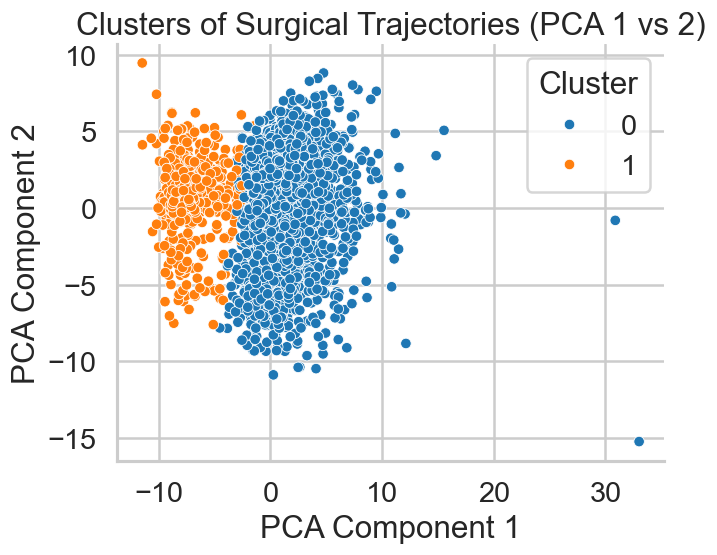

[export] Wrote per-patient PCA points -> exports/cluster_points_pca.csv
[export] Wrote KMeans centroids -> exports/cluster_centroids_pca2.csv / pcall.csv
[export] Wrote PCA metadata -> exports/pca_explained_variance.csv / pca_loadings.csv


In [ ]:
# Use combined model_combined_dataset.csv to cluster surgeries by surgical trajectories via PCA and KMeans.

print(prune_frac, drop_frac)

# User‐configurable thresholds drop_frac (missingness) and prune_frac (collinearity)

# 1) Load combined dataset
df = pd.read_csv('model_combined_dataset.csv')

# 2) Compute ICU flag if missing
if 'icu_admit' not in df.columns and 'icu_los_min' in df.columns:
    df['icu_admit'] = (df['icu_los_min'] > 4320).astype(int)

# 3) Drop leakage columns
leak_cols = [
    'subject_id','op_id','died_inhospital',
    'icu_admit','icu_los_min','allcause_death_time'
]
df_model = df.drop(columns=[c for c in leak_cols if c in df.columns])

# 4) Identify dynamic + coupling candidate features
dynamic_prefixes = [
    'mean_','std_','slope_','auc_','min_','max_',
    'avg_rate_','duration_','num_events_','total_dose_'
]
coupling_tokens = ['_lag','_slope','_ri']
candidates = [
    c for c in df_model.columns
    if any(c.startswith(pref) for pref in dynamic_prefixes)
       or any(tok in c for tok in coupling_tokens)
]
print(f"Candidate features before missingness filter: {len(candidates)}")

# 5) Compute true missingness from pre-imputation dynamics
dyn_missing = pd.read_csv('dynamic_features_vitals.csv').isna().mean()

# 6) Filter out >drop_frac missing, except protected prefixes
protected = ['avg_rate_','duration_','num_events_','total_dose_'] + coupling_tokens
feature_cols = [
    f for f in candidates
    if (dyn_missing.get(f, 0) <= drop_frac)
       or any(f.startswith(pref) for pref in protected)
]
print(f"Features after missingness filter: {len(feature_cols)}")

# 7) Build feature matrix, select numeric, zero‐impute
X_full = (
    df_model[feature_cols]
    .select_dtypes(include=[np.number])
    .fillna(0)
)

# 8) Prune collinear features (|r| > prune_frac)
corr = X_full.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > prune_frac)]
print(f"Dropping {len(to_drop)} highly‐correlated features (|r|>{prune_frac}):\n{to_drop}\n")

feature_cols_pruned = [f for f in feature_cols if f not in to_drop]
X = X_full[feature_cols_pruned]

# 9) Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 10) PCA to 10 components
pca   = PCA(n_components=10, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# 11) Silhouette scan for k=2..6
scores = {}
for k in range(2, 7):
    km   = KMeans(n_clusters=k, random_state=42)
    labs = km.fit_predict(X_pca)
    scores[k] = silhouette_score(X_pca, labs)
best_k = max(scores, key=scores.get)
print("Silhouette scores:", scores)
print("→ Best k =", best_k)

# 12) Final K-means clustering
km = KMeans(n_clusters=best_k, random_state=42)
df['cluster'] = km.fit_predict(X_pca)

# 13) Save clustered dataset
outpath = 'model_combined_dataset_clustered_withmissingness.csv'
df.to_csv(outpath, index=False)
print(f"Saved clustered dataset to '{outpath}'")

# 14) Summarize cluster outcomes
summary = (
    df[['cluster','died_inhospital','icu_admit']]
      .groupby('cluster')
      .agg(
          size=('cluster','count'),
          mortality=('died_inhospital','mean'),
          icu_rate=('icu_admit','mean')
      )
      .reset_index()
)
print("\nCluster outcome summary:")
print(summary.to_string(index=False))

# 14b) ICU‐LOS summary by cluster (minutes & % of stays)
#    3 days = 4320 minutes
los_stats = df.groupby('cluster')['icu_los_min'].agg(
    mean_icu_los_min   = 'mean',
    median_icu_los_min = 'median'
)
los_stats['pct_long_ICU']  = df.groupby('cluster')['icu_los_min'].apply(lambda x: (x > 4320).mean() * 100)
los_stats['pct_short_ICU'] = df.groupby('cluster')['icu_los_min'].apply(lambda x: (x <= 4320).mean() * 100)

print("\nICU‐LOS summary by cluster (minutes & % of stays):")
print(los_stats.round({'mean_icu_los_min':1,'median_icu_los_min':1,'pct_long_ICU':1,'pct_short_ICU':1}))

# 14c) Chi-square test for long vs short ICU stays
df['long_ICU'] = df['icu_los_min'] > 4320
ct_long = pd.crosstab(df['cluster'], df['long_ICU'])
chi2, p, _, _ = chi2_contingency(ct_long)
print(f"\nChi² test for long ICU stays (>3 days) vs. cluster: χ²={chi2:.2f}, p={p:.3e}")
print(ct_long)


# 15) Chi-square tests
for outcome in ['died_inhospital','icu_admit']:
    ct = pd.crosstab(df['cluster'], df[outcome])
    chi2, p, _, _ = chi2_contingency(ct)
    print(f"\nChi² test for {outcome} vs. cluster: χ²={chi2:.2f}, p={p:.3e}")
    print(ct)

# 16) Procedure distribution per cluster (one-hot PCS)
pcs_cols = [c for c in df.columns if re.fullmatch(r'proc_[A-Za-z0-9]+', c)]
if pcs_cols:
    proc_dist = df.groupby('cluster')[pcs_cols].mean()
    print("\nProcedure frequency by cluster:")
    print(proc_dist)

# 17) 2D PCA scatter plot
plt.figure(figsize=(6,5))
sns.scatterplot(
    x=X_pca[:,0], y=X_pca[:,1],
    hue=df['cluster'], palette='tab10', s=40
)
plt.title("Clusters of Surgical Trajectories (PCA 1 vs 2)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster', loc='best')
plt.tight_layout()
plt.show()


# ============= EXPORT INDIVIDUAL DOTS & PCA/KMeans METADATA =============

os.makedirs("exports", exist_ok=True)

# 1) Build an ID table (use subject_id/op_id if present; else row index)
id_cols = [c for c in ['subject_id', 'op_id'] if c in df.columns]
if id_cols:
    ids = df[id_cols].copy()
else:
    ids = pd.DataFrame({'row_index': np.arange(len(df))})

# 2) All points in PCA space (+ cluster labels)
pts = ids.copy()
pts['cluster'] = df['cluster'].astype(int)
pts['PCA1'] = X_pca[:, 0]
pts['PCA2'] = X_pca[:, 1]
# (Optional) include the rest of the PCs you computed (PC3..PC10)
for i in range(2, X_pca.shape[1]):
    pts[f'PCA{i+1}'] = X_pca[:, i]

# 3) Per-sample silhouette (quality of assignment)
pts['silhouette'] = silhouette_samples(X_pca, df['cluster'])

# 4) Distances to each centroid (in PCA space) + margin
D = km.transform(X_pca)  # shape: (n_samples, best_k)
dist_cols = [f'dist_to_c{j}' for j in range(best_k)]
dist_df = pd.DataFrame(D, columns=dist_cols)
nearest = D.min(axis=1)
second  = np.partition(D, 1, axis=1)[:, 1]
pts = pd.concat([pts.reset_index(drop=True), dist_df.reset_index(drop=True)], axis=1)
pts['nearest_dist'] = nearest
pts['second_nearest_dist'] = second
pts['margin'] = second - nearest  # larger = more confident

# 5) Write the main “all dots” file
pts.to_csv("exports/cluster_points_pca.csv", index=False)
print("[export] Wrote per-patient PCA points -> exports/cluster_points_pca.csv")

# 6) Centroids in PCA space (2D and full)
cent_full = pd.DataFrame(km.cluster_centers_, columns=[f'PCA{i+1}' for i in range(X_pca.shape[1])])
cent_full['cluster'] = np.arange(best_k)
cent_full[['cluster','PCA1','PCA2']].to_csv("exports/cluster_centroids_pca2.csv", index=False)
cent_full.to_csv("exports/cluster_centroids_pcall.csv", index=False)
print("[export] Wrote KMeans centroids -> exports/cluster_centroids_pca2.csv / pcall.csv")

# 7) PCA explained variance + loadings (for biplots or feature arrows)
expl = pd.DataFrame({
    'component': [f'PC{i+1}' for i in range(X_pca.shape[1])],
    'explained_variance_ratio': pca.explained_variance_ratio_
})
expl.to_csv("exports/pca_explained_variance.csv", index=False)
loadings = pd.DataFrame(
    pca.components_.T, index=feature_cols_pruned,
    columns=[f'PC{i+1}' for i in range(X_pca.shape[1])]
).reset_index().rename(columns={'index': 'feature'})
loadings.to_csv("exports/pca_loadings.csv", index=False)
print("[export] Wrote PCA metadata -> exports/pca_explained_variance.csv / pca_loadings.csv")
# =======================================================================



In [583]:
# quick sanity check to make sure input features for both supervised and clustering are equal

import pandas as pd
import numpy as np

print(prune_frac, drop_frac)

# Parameters must match your pipelines drop_frac and prune_frac

# 1) Recompute clustering feature list
df_clust = pd.read_csv('model_combined_dataset.csv')
dyn_pfx   = ['mean_','std_','slope_','auc_','min_','max_',
             'avg_rate_','duration_','num_events_','total_dose_']
coup_tok  = ['_lag','_slope','_ri']
# a) candidate dyn+coupling
cands = [
    c for c in df_clust.columns
    if any(c.startswith(p) for p in dyn_pfx)
       or any(tok in c for tok in coup_tok)
]
# b) missingness filter
dyn_missing = pd.read_csv('dynamic_features_vitals.csv').isna().mean()
protected   = ['avg_rate_','duration_','num_events_','total_dose_'] + coup_tok
clust_feats = [
    f for f in cands
    if (dyn_missing.get(f, 0) <= drop_frac)
       or any(f.startswith(p) for p in protected)
]
# c) build X_clust and prune collinear
Xc = df_clust[clust_feats].select_dtypes(include=np.number).fillna(0)
corr_c = Xc.corr().abs()
upper_c = corr_c.where(np.triu(np.ones(corr_c.shape), k=1).astype(bool))
drop_c  = [col for col in upper_c.columns if any(upper_c[col] > prune_frac)]
clust_final = sorted([f for f in clust_feats if f not in drop_c])

# 2) Recompute supervised feature list
df_sup = pd.read_csv('model_combined_dataset_clustered.csv')
# a) all numeric minus leak
num_feats = df_sup.select_dtypes(include=np.number).columns.tolist()
leak_cols = [
    'subject_id','op_id','icu_admit','icu_los_min','icuin_time','icuout_time',
    'cluster','died_inhospital','allcause_death_time','inhosp_death_time',
    'age','sex_num','asa'
]
sup_feats = [f for f in num_feats if f not in leak_cols]
# b) missingness filter
sup_feats = [
    f for f in sup_feats
    if (dyn_missing.get(f, 0) <= drop_frac)
       or any(f.startswith(p) for p in protected)
]
# c) build X_sup and prune collinear
Xs = df_sup[sup_feats].select_dtypes(include=np.number).fillna(0)
corr_s = Xs.corr().abs()
upper_s = corr_s.where(np.triu(np.ones(corr_s.shape), k=1).astype(bool))
drop_s  = [col for col in upper_s.columns if any(upper_s[col] > prune_frac)]
sup_final = sorted([f for f in sup_feats if f not in drop_s])

# 3) Compare final sets
only_supervised = sorted(set(sup_final) - set(clust_final))
only_clustering = sorted(set(clust_final) - set(sup_final))

print(f"Features only in supervised ({len(only_supervised)}):\n{only_supervised}\n")
print(f"Features only in clustering ({len(only_clustering)}):\n{only_clustering}\n")


0.85 0.7
Features only in supervised (0):
[]

Features only in clustering (0):
[]



0.85 0.7
Before missingness filter: 412
After missingness filter: 292
Dropped 45 from A, 12 from B

Feature-Split (B→cluster) results:
  Acc    0.979
  BalAcc 0.970
  ROC AUC0.997
  κ      0.942
  ARI    0.912
  NMI    0.821


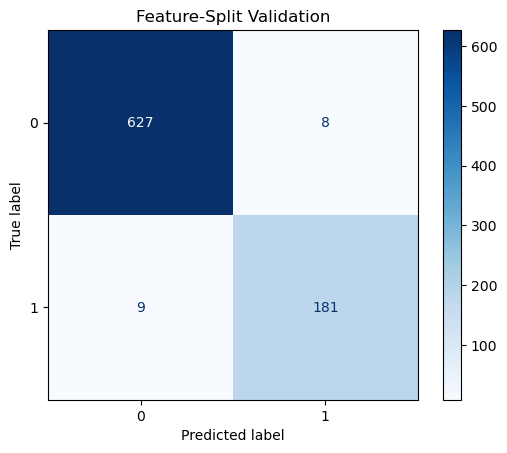


Temporal (early→late) results:
  Acc    0.980
  BalAcc 0.967
  ROC AUC0.997
  κ      0.925
  ARI    0.900
  NMI    0.792


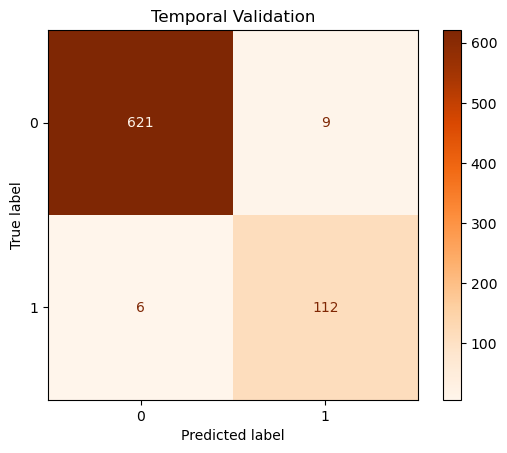

In [ ]:
# Feature recovery validation.

# ──────────────────────────────────────────────────────────────────────────────
# 1) LOAD FINAL CLUSTERED DATASET
dfc = pd.read_csv('model_combined_dataset_clustered.csv')
X_all = dfc[features].fillna(0)
y_all = dfc['cluster'].astype(int)

# ──────────────────────────────────────────────────────────────────────────────
# 2) FEATURE-SPLIT VALIDATION
mid     = len(features) // 2
A_feats = features[:mid]
B_feats = features[mid:]

def prune(df, thresh):
    c    = df.corr().abs()
    upper= c.where(np.triu(np.ones(c.shape), k=1).astype(bool))
    drops= [col for col in upper.columns if any(upper[col] > thresh)]
    return df.drop(columns=drops), drops

XA, drops_A = prune(X_all[A_feats], prune_frac)
XB, drops_B = prune(X_all[B_feats], prune_frac)
print(f"Dropped {len(drops_A)} from A, {len(drops_B)} from B")

# Train/test on B → cluster
Xtr, Xte, ytr, yte = train_test_split(
    XB, y_all, stratify=y_all, test_size=0.3, random_state=42
)
Xtr_sm, ytr_sm = SMOTE(random_state=42).fit_resample(Xtr, ytr)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(Xtr_sm, ytr_sm)
y_pred  = clf.predict(Xte)
y_proba = clf.predict_proba(Xte)[:,1]

print("\nFeature-Split (B→cluster) results:")
print(f"  Acc    {accuracy_score(yte,y_pred):.3f}")
print(f"  BalAcc {balanced_accuracy_score(yte,y_pred):.3f}")
print(f"  ROC AUC{roc_auc_score(yte,y_proba):.3f}")
print(f"  κ      {cohen_kappa_score(yte,y_pred):.3f}")
print(f"  ARI    {adjusted_rand_score(yte,y_pred):.3f}")
print(f"  NMI    {normalized_mutual_info_score(yte,y_pred):.3f}")


# … after y_pred = clf.predict(X_te):
cm = confusion_matrix(yte, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=clf.classes_  # or ['Cluster 0','Cluster 1']
)
disp.plot(cmap='Blues', values_format='d')
plt.title("Feature-Split Validation")
plt.show()


# ──────────────────────────────────────────────────────────────────────────────
# 3) TEMPORAL VALIDATION (early→late by opdate)
ops = pd.read_csv('data/extracted_operations.csv')
ops['opdate'] = pd.to_datetime(ops['opdate'], errors='coerce')
dfc2 = dfc.merge(ops[['op_id','opdate']], on='op_id', how='left')

cut   = dfc2['opdate'].quantile(0.7)
early = dfc2[dfc2['opdate'] <= cut]
late  = dfc2[dfc2['opdate']  > cut]

X1 = early[features].fillna(0).drop(columns=drops_B, errors='ignore')
y1 = early['cluster'].astype(int)
X2 = late [features].fillna(0).drop(columns=drops_B, errors='ignore')
y2 = late ['cluster'].astype(int)

X1_sm, y1_sm = SMOTE(random_state=42).fit_resample(X1, y1)
clf2 = RandomForestClassifier(n_estimators=100, random_state=42)
clf2.fit(X1_sm, y1_sm)
y2_pred, y2_proba = clf2.predict(X2), clf2.predict_proba(X2)[:,1]

print("\nTemporal (early→late) results:")
print(f"  Acc    {accuracy_score(y2,y2_pred):.3f}")
print(f"  BalAcc {balanced_accuracy_score(y2,y2_pred):.3f}")
print(f"  ROC AUC{roc_auc_score(y2,y2_proba):.3f}")
print(f"  κ      {cohen_kappa_score(y2,y2_pred):.3f}")
print(f"  ARI    {adjusted_rand_score(y2,y2_pred):.3f}")
print(f"  NMI    {normalized_mutual_info_score(y2,y2_pred):.3f}")

cm2 = confusion_matrix(y2, y2_pred)
disp2 = ConfusionMatrixDisplay(cm2, display_labels=clf2.classes_)
disp2.plot(cmap='Oranges', values_format='d')
plt.title("Temporal Validation")
plt.show()



0.85 0.7
Before missingness filter: 412
After missingness filter: 292
Kept 224 features (pruned 68)
Silhouette (k=2): 0.25275574547612367
Bootstrap ARI: 0.709 ± 0.237


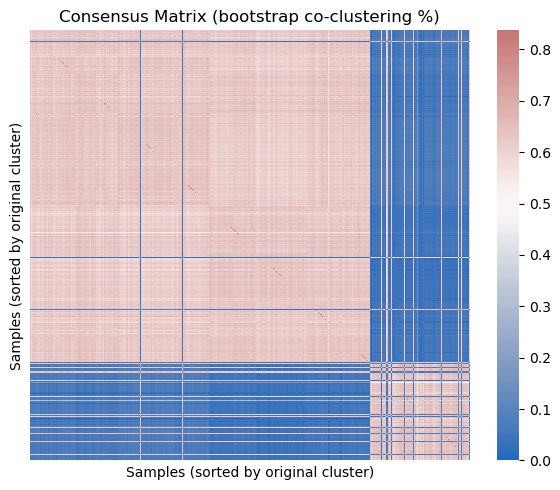

In [ ]:
# Bootstrap consensus analysis

# ─── 1) Load clustered labels & build PCA basis ────────────────────────
clustered = pd.read_csv('model_combined_dataset_clustered.csv')
X        = clustered[features].fillna(clustered[features].median())
y_cluster= clustered['cluster'].astype(int).values

# scale → PCA
Xs = StandardScaler().fit_transform(X)
Xp = PCA(n_components=10, random_state=42).fit_transform(Xs)

# sanity: silhouette
print("Silhouette (k=2):",
      silhouette_score(Xp, y_cluster.round()))

# ─── 2) Bootstrap Consensus + ARI ──────────────────────────────────
n, n_boot, frac = len(clustered), 1000, 0.8
rng      = np.random.RandomState(42)
aris     = []
cons_mat = np.zeros((n, n), float)

for _ in range(n_boot):
    idx = rng.choice(n, size=int(frac*n), replace=False)
    km  = KMeans(n_clusters=2, random_state=42).fit(Xp[idx])
    lab = km.labels_
    aris.append(adjusted_rand_score(y_cluster[idx], lab))
    # accumulate co-cluster counts
    for i, ii in enumerate(idx):
        for j, jj in enumerate(idx):
            if lab[i] == lab[j]:
                cons_mat[ii, jj] += 1

# normalize to fraction
cons_mat /= n_boot
print(f"Bootstrap ARI: {np.mean(aris):.3f} ± {np.std(aris):.3f}")

# ─── 3) Consensus Heatmap ────────────────────────────────────────────
order = np.argsort(y_cluster)
plt.figure(figsize=(6,5))
sns.heatmap(
    cons_mat[order][:, order],
    cmap='vlag', center=0.5,
    xticklabels=False, yticklabels=False
)
plt.title("Consensus Matrix (bootstrap co‐clustering %)")
plt.xlabel("Samples (sorted by original cluster)")
plt.ylabel("Samples (sorted by original cluster)")
plt.tight_layout()
plt.show()


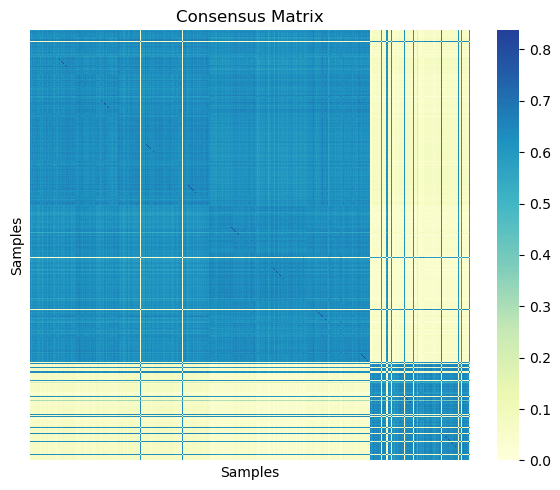

In [ ]:
# Change heatmap color
order = np.argsort(y_cluster)
plt.figure(figsize=(6,5))
sns.heatmap(
    cons_mat[order][:, order],
    cmap='YlGnBu', center=0.5,
    xticklabels=False, yticklabels=False
)
plt.title("Consensus Matrix")
plt.xlabel("Samples")
plt.ylabel("Samples")
plt.tight_layout()
plt.show()

0.85 0.7
423
303
292
Dropping 68 highly‐correlated features:
['auc_art_mbp', 'auc_art_sbp', 'auc_hr', 'auc_nibp_mbp', 'auc_nibp_sbp', 'auc_pap_mbp', 'auc_pap_sbp', 'auc_rr', 'auc_vt', 'max_cpat', 'max_nibp_mbp', 'max_nibp_sbp', 'max_pap_mbp', 'max_pap_sbp', 'max_pplat', 'mean_art_mbp', 'mean_bis', 'mean_ci', 'mean_cpat', 'mean_ebl', 'mean_fio2', 'mean_nibp_dbp', 'mean_nibp_mbp', 'mean_nibp_sbp', 'mean_ntgi', 'mean_pap_dbp', 'mean_pap_mbp', 'mean_pap_sbp', 'mean_pmean', 'mean_pplat', 'mean_psa', 'mean_sti', 'mean_stii', 'mean_stiii', 'mean_uo', 'mean_vt', 'min_bis', 'min_ci', 'min_cpat', 'min_ebl', 'min_nibp_dbp', 'min_nibp_mbp', 'min_nibp_sbp', 'min_ntgi', 'min_pplat', 'slope_nibp_mbp', 'std_cpat', 'std_hs', 'std_nibp_mbp', 'std_nibp_sbp', 'std_ns', 'std_ntgi', 'std_o2', 'std_pap_dbp', 'std_pap_sbp', 'std_pplat', 'std_psa', 'std_rbc', 'std_sti', 'std_stiii', 'std_uo', 'num_events_pepi', 'total_dose_dopai', 'total_dose_eph', 'total_dose_epi', 'total_dose_mlni', 'total_dose_pepi', 'total

/opt/anaconda3/envs/inspire/lib/python3.13/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/opt/anaconda3/envs/inspire/lib/python3.13/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


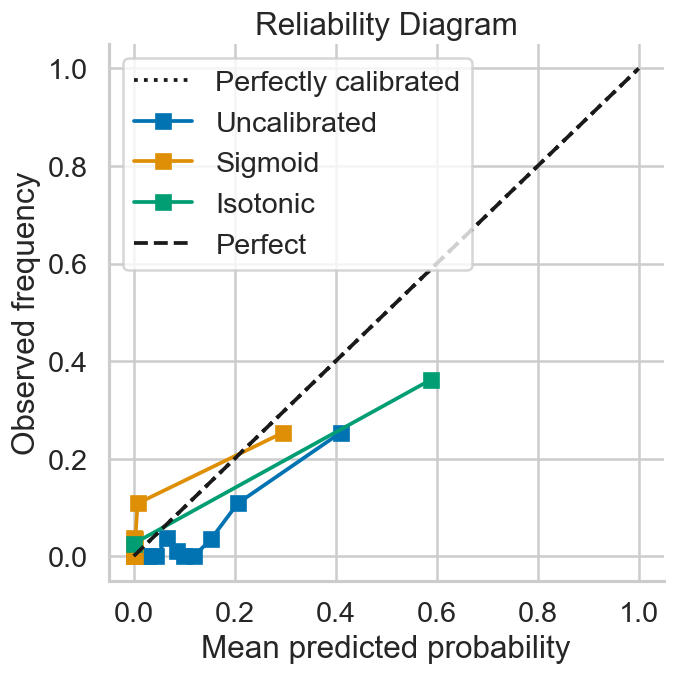

Brier scores:
  Uncalibrated: 0.042
      Sigmoid: 0.041
     Isotonic: 0.043



/var/folders/8z/vgl7z7cj5dl4m8w2mt85hhyh0000gn/T/ipykernel_5328/3077252684.py:149: RuntimeWarning: divide by zero encountered in scalar divide
  return (TP/N) - (FP/N) * (thresh/(1-thresh))
/var/folders/8z/vgl7z7cj5dl4m8w2mt85hhyh0000gn/T/ipykernel_5328/3077252684.py:149: RuntimeWarning: invalid value encountered in scalar multiply
  return (TP/N) - (FP/N) * (thresh/(1-thresh))
/var/folders/8z/vgl7z7cj5dl4m8w2mt85hhyh0000gn/T/ipykernel_5328/3077252684.py:162: RuntimeWarning: divide by zero encountered in scalar divide
  nb_all  = [ p_mean - (1-p_mean)*(t/(1-t)) for t in thresholds ]


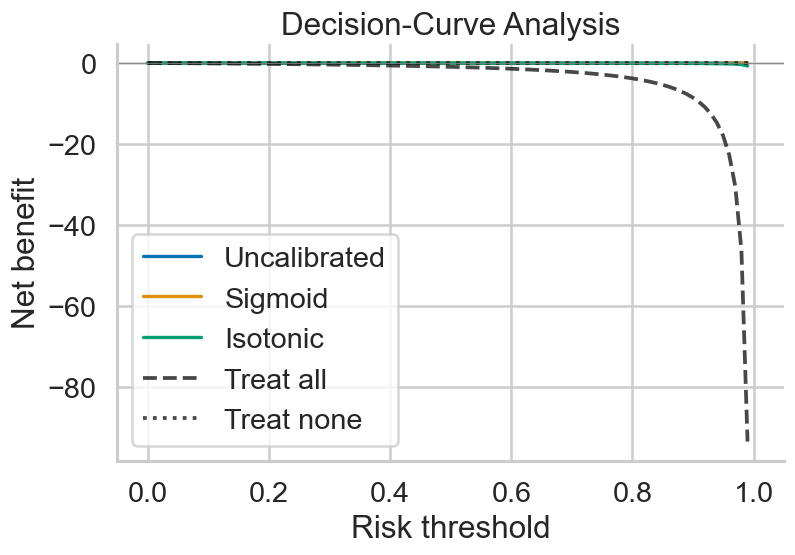


Net benefit at key thresholds:
threshold      0.05   0.10   0.20   0.25   0.30   0.35   0.40   0.50   0.60  \
treat_all    -0.005 -0.061 -0.194 -0.274 -0.365 -0.469 -0.592 -0.910 -1.388   
treat_none    0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
Uncalibrated  0.008 -0.007  0.002  0.000  0.003  0.000  0.002 -0.001 -0.005   
Sigmoid       0.019  0.015  0.012  0.010  0.008  0.007  0.004 -0.002 -0.011   
Isotonic      0.019  0.015  0.012  0.010  0.008  0.005  0.003 -0.001 -0.010   

threshold      0.70   0.80   0.90  
treat_all    -2.184 -3.776 -8.552  
treat_none    0.000  0.000  0.000  
Uncalibrated  0.002  0.001  0.000  
Sigmoid      -0.025 -0.040 -0.047  
Isotonic     -0.024 -0.045 -0.069  

Top 15 pruned-feature importances:
  max_rbc                        0.0273
  total_dose_nepi                0.0256
  avg_rate_epii                  0.0234
  num_events_nepi                0.0218
  dobui_lag                      0.0212
  num_events_epii                0.0210
 

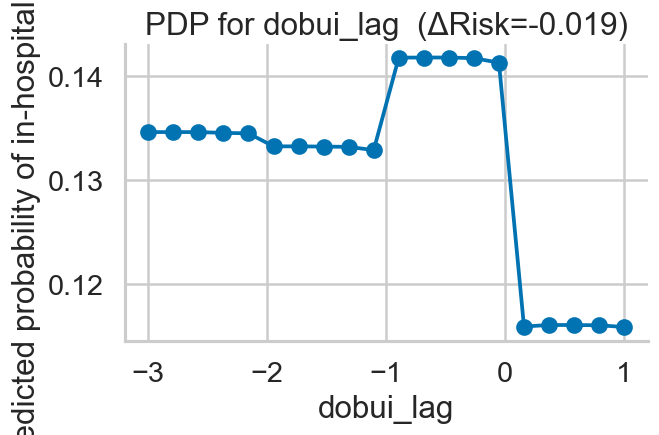

 • total_dose_nepi: ΔRisk from 0.00 → 0.32 = 0.025


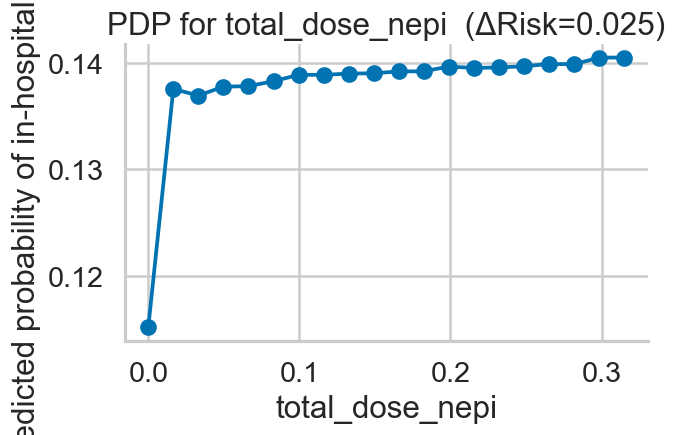

 • avg_rate_nepi: ΔRisk from 0.00 → 0.04 = 0.018


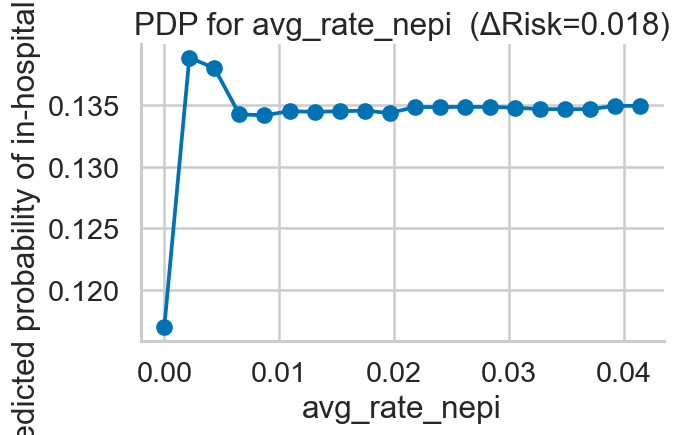

 • num_events_nepi: ΔRisk from 0.00 → 12.00 = 0.005


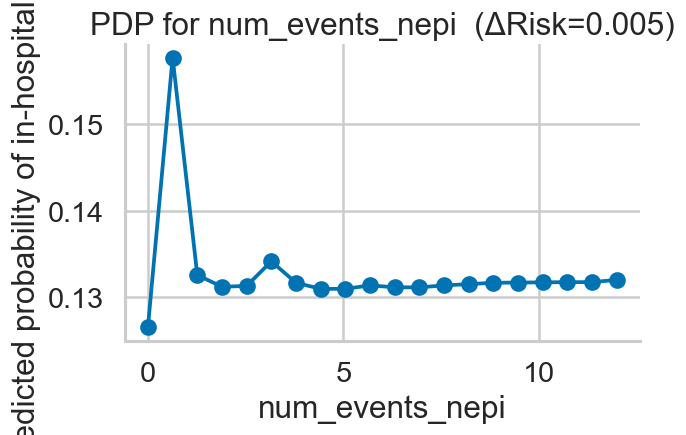

 • total_dose_dobui: ΔRisk from 0.00 → 12.50 = 0.010


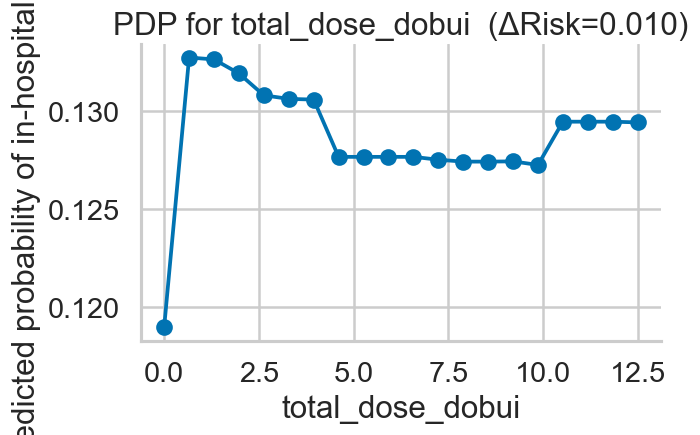

[export] Reliability points -> exports_death/reliability_points.csv
[export] Net benefit curves -> exports_death/net_benefit_points.csv
[export] Net benefit per-100 summary -> exports_death/net_benefit_summary_per100.csv
[export] PDP -> exports_death/pdp/pdp_total_dose_dobui.csv
[export] PDP (combined) -> exports_death/pdp/pdp_all.csv


In [ ]:
# Supervised prediction of in-hospital death via RandomForest 

# (leakage drop + missingness drop + SMOTE + collinearity pruning)
# RandomForest prediction model, net-benefit analysis, permutation importance + GINI importances for interpretability

# 1) Compute true missingness from dynamic features (pre-imputation)
dyn = pd.read_csv('dynamic_features_vitals.csv')
missing_pct = dyn.isna().mean()

# 2) Load final clustered dataset for modeling (but not included in analysis to prevent leakage of information)
df = pd.read_csv('model_combined_dataset_clustered.csv')

# 3) Define numeric features in clustered data
numeric_feats = df.select_dtypes(include=[np.number]).columns.tolist()
print(len(numeric_feats))

# 4) Select features with ≤80% missing in dyn or protected prefixes
protected_prefixes = ['avg_rate_', 'duration_', 'num_events_', 'total_dose_', '_lag', '_slope', '_ri']
keep_feats = [
    f for f in numeric_feats
    if (missing_pct.get(f, 0) <= drop_frac) or any(f.startswith(pref) for pref in protected_prefixes)
]
print(len(keep_feats))

# 5) Extract target and drop leakage columns
y = df['died_inhospital'].astype(int)
leak_cols = [
    'subject_id','op_id','icu_admit','icu_los_min','icuin_time','icuout_time',
    'cluster','died_inhospital','allcause_death_time','inhosp_death_time', 'asa', 'sex_num', 'age'
]
feature_pool = [f for f in keep_feats if f not in leak_cols]
print(len(feature_pool))

# 6) Build feature matrix and zero‐impute
X_full = df[feature_pool].fillna(0)

# 7) Prune collinear features (|r| > prune_frac)
corr = X_full.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > prune_frac)]
print(f"Dropping {len(to_drop)} highly‐correlated features:\n{to_drop}\n")
feature_cols = [f for f in feature_pool if f not in to_drop]
X = X_full[feature_cols]

# 8) Train/test split
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 9) SMOTE on training set
X_tr_sm, y_tr_sm = SMOTE(random_state=42).fit_resample(X_tr, y_tr)

# 10) Train Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_tr_sm, y_tr_sm)

# 11) Predict & evaluate
y_pred = clf.predict(X_te)
y_proba = clf.predict_proba(X_te)[:, 1]

print("Model Performance:")
print(f"Accuracy       : {accuracy_score(y_te, y_pred):.3f}")
print(f"Balanced Acc.  : {balanced_accuracy_score(y_te, y_pred):.3f}")
print(f"Sensitivity    : {recall_score(y_te, y_pred, pos_label=1):.3f}")
print(f"Specificity    : {recall_score(y_te, y_pred, pos_label=0):.3f}")
print(f"Precision      : {precision_score(y_te, y_pred, pos_label=1):.3f}")
print(f"ROC AUC        : {roc_auc_score(y_te, y_proba):.3f}")
print(f"Cohen’s κ      : {cohen_kappa_score(y_te, y_pred):.3f}")
print(f"Adj. Rand      : {adjusted_rand_score(y_te, y_pred):.3f}")
print(f"NMI            : {normalized_mutual_info_score(y_te, y_pred):.3f}")



# ==== Decision-Calibration Analysis (fixed) ===== #

# 1) Fit post-hoc calibrators
calibrators = {
    "Uncalibrated": None,
    "Sigmoid": CalibratedClassifierCV(estimator=clf, method="sigmoid",  cv="prefit"),
    "Isotonic":  CalibratedClassifierCV(estimator=clf, method="isotonic", cv="prefit")
}

probas = {"Uncalibrated": y_proba}
for name, calib in calibrators.items():
    if name == "Uncalibrated":
        continue
    calib.fit(X_tr_sm, y_tr_sm)
    probas[name] = calib.predict_proba(X_te)[:,1]

# 2) Reliability diagram
plt.figure(figsize=(6,6))
ax = plt.gca()

for name, p in probas.items():
    disp = CalibrationDisplay.from_predictions(
        y_true=y_te,
        y_prob=p,
        n_bins=10,
        strategy="quantile",
        name=name,
        ax=ax
    )
# perfect line
ax.plot([0,1], [0,1], "k--", label="Perfect")
ax.set_title("Reliability Diagram")
ax.set_xlabel("Mean predicted probability")
ax.set_ylabel("Observed frequency")
ax.legend(loc="best")
plt.tight_layout()
plt.show()

# Print Brier scores
print("Brier scores:")
for name, p in probas.items():
    print(f"  {name:>11s}: {brier_score_loss(y_te, p):.3f}")
print()

# 3) Decision-Curve Analysis
def net_benefit(y_true, y_prob, thresh):
    N    = len(y_true)
    pred = (y_prob >= thresh).astype(int)
    TP   = np.logical_and(pred==1, y_true==1).sum()
    FP   = np.logical_and(pred==1, y_true==0).sum()
    return (TP/N) - (FP/N) * (thresh/(1-thresh))

# build threshold grid over the actual prob range
all_probs  = np.concatenate(list(probas.values()))
thresholds = np.linspace(all_probs.min(), all_probs.max(), 100)

plt.figure(figsize=(7,5))
for name, p in probas.items():
    nb = [net_benefit(y_te, p, t) for t in thresholds]
    plt.plot(thresholds, nb, lw=2, label=name)

# baseline curves
p_mean = y_te.mean()
nb_all  = [ p_mean - (1-p_mean)*(t/(1-t)) for t in thresholds ]
nb_none = [ 0                          for _ in thresholds ]
plt.plot(thresholds, nb_all,  'k--', label="Treat all",  alpha=0.8)
plt.plot(thresholds, nb_none,'k:',  label="Treat none", alpha=0.8)

plt.axhline(0, color='gray', lw=0.5)
plt.xlabel("Risk threshold")
plt.ylabel("Net benefit")
plt.title("Decision-Curve Analysis")
plt.legend(loc="best")
plt.tight_layout()
plt.show()


# === Net‐Benefit Table at Selected Thresholds ===

thresholds = [0.05, 0.10, 0.20, 0.25, 0.30, 0.35, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90]

def net_benefit(y_true, y_prob, t):
    N   = len(y_true)
    pred = (y_prob >= t).astype(int)
    TP  = np.logical_and(pred==1, y_true==1).sum()
    FP  = np.logical_and(pred==1, y_true==0).sum()
    return (TP/N) - (FP/N)*(t/(1-t))

rows = []
p_mean = y_te.mean()
for t in thresholds:
    row = {"threshold": t,
           "treat_all": p_mean - (1-p_mean)*(t/(1-t)),
           "treat_none": 0.0}
    for name, p in probas.items():
        row[name] = net_benefit(y_te, p, t)
    rows.append(row)

df_nb = pd.DataFrame(rows).set_index("threshold").T
print("\nNet benefit at key thresholds:")
print(df_nb.round(3))
print()

# === Interpretability Analysis === #

# 1) Top-15 Gini feature importances 
importances = pd.Series(clf.feature_importances_, index=feature_cols)
top15 = importances.sort_values(ascending=False).head(15)
print("Top 15 pruned-feature importances:")
for feat, imp in top15.items():
    print(f"  {feat:<30} {imp:.4f}")
print()

# 2) Permutation importance (alpha < 0.05)
perm = permutation_importance(
    clf, X_te, y_te,
    n_repeats=200, random_state=42, n_jobs=-1
)
pi = pd.DataFrame({
    'mean_imp': perm.importances_mean,
    'std_imp':  perm.importances_std
}, index=feature_cols)
pi['p_val']       = [np.mean(vals <= 0.0) for vals in perm.importances]
pi['significant'] = pi['p_val'] < 0.05
sig_feats = pi[pi['significant']]
print(sig_feats)
print()

top_perm = pi.sort_values('mean_imp', ascending=False).head(15)
print("Top 15 permutation importances with p-values:")
print(top_perm[['mean_imp','std_imp','p_val','significant']])


# === Partial Dependence Plots Analysis === # 

# All significant features + all norepinephrine features among the top 15 permutation to support sympathomimetic theory.
# Identify dobui_lag plus all “nepi” features among the top 15 permutation importances
top_perm = pi.sort_values('mean_imp', ascending=False).head(15)
nepi_feats = [feat for feat in top_perm.index if 'nepi' in feat]
pdp_feats = ['dobui_lag'] + nepi_feats + ['total_dose_dobui']

# Wrap test set in a DataFrame for column access
X_test_df = pd.DataFrame(X_te, columns=feature_cols)

print("PDPs for selected dobui and nepi features:\n")
for feat in pdp_feats:
    if feat not in X_test_df.columns:
        continue

    # Compute partial dependence using the same parameters as before
    pdp_res = partial_dependence(
        estimator       = clf,
        X               = X_test_df,
        features        = [feat],
        kind            = "average",
        grid_resolution = 20,
        percentiles     = (0.1, 0.9)
    )

    # Extract grid and average effect
    if 'values' in pdp_res:
        grid = pdp_res['values'][0]
    elif 'grid_values' in pdp_res:
        grid = pdp_res['grid_values'][0]
    else:
        raise KeyError(f"No grid found in PDP result for {feat}")

    avg = pdp_res['average'][0]

    # Compute Δ-risk
    delta = avg[-1] - avg[0]
    print(f" • {feat}: ΔRisk from {grid[0]:.2f} → {grid[-1]:.2f} = {delta:.3f}")

    # Plot PDP
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(grid, avg, marker='o')
    ax.set_title(f"PDP for {feat}  (ΔRisk={delta:.3f})")
    ax.set_xlabel(feat)
    ax.set_ylabel("Predicted probability of in-hospital death")
    plt.tight_layout()
    plt.show()


# ==== Export Data Tools === # 
os.makedirs("exports_death/pdp", exist_ok=True)

# 1) Reliability diagram (quantile bins, per model) 
def export_reliability_points(y_true, probas_dict, n_bins=10, out_csv="exports_death/reliability_points.csv"):
    rows = []
    for name, y_prob in probas_dict.items():
        df = pd.DataFrame({"y": y_true.astype(int), "p": y_prob})
        # Quantile bins; drop duplicate edges if probs are tied
        df["bin"] = pd.qcut(df["p"], q=n_bins, duplicates="drop")
        gb = df.groupby("bin", observed=False)
        for i, (interval, grp) in enumerate(gb, start=1):
            rows.append({
                "model": name,
                "bin_id": i,
                "bin_lower": float(interval.left)  if pd.notna(interval.left)  else np.nan,
                "bin_upper": float(interval.right) if pd.notna(interval.right) else np.nan,
                "mean_pred": grp["p"].mean(),
                "observed_rate": grp["y"].mean(),
                "n_in_bin": int(grp.shape[0])
            })
    rel = pd.DataFrame(rows)
    rel.to_csv(out_csv, index=False)
    print(f"[export] Reliability points -> {out_csv}")

#  2) Decision-curve / Net benefit (full grid + per-100 table)
def export_net_benefit_points(y_true, probas_dict,
                              thresholds=None,
                              curve_csv="exports_death/net_benefit_points.csv",
                              summary_csv="exports_death/net_benefit_summary_per100.csv",
                              key_thresholds=(0.05,0.10,0.20,0.25,0.30)):
    y_true = np.asarray(y_true).astype(int)
    p_mean = y_true.mean()
    all_probs = np.concatenate(list(probas_dict.values()))
    lo = max(0.01, all_probs.min() + 1e-6)
    hi = min(0.99, all_probs.max() - 1e-6)
    if thresholds is None:
        thresholds = np.linspace(lo, hi, 200)

    def nb_at(y, p, t):
        pred = (p >= t).astype(int)
        TP   = ((pred==1) & (y==1)).sum()
        FP   = ((pred==1) & (y==0)).sum()
        N    = len(y)
        w    = t/(1-t)
        return (TP/N) - (FP/N)*w

    # Curves (long form)
    rows = []
    for t in thresholds:
        nb_all = p_mean - (1-p_mean)*(t/(1-t))
        for name, p in probas_dict.items():
            rows.append({"threshold": t, "curve": name, "net_benefit": nb_at(y_true, p, t)})
        rows.append({"threshold": t, "curve": "Treat all",  "net_benefit": nb_all})
        rows.append({"threshold": t, "curve": "Treat none", "net_benefit": 0.0})
    curve_df = pd.DataFrame(rows)
    curve_df.to_csv(curve_csv, index=False)
    print(f"[export] Net benefit curves -> {curve_csv}")

    # Per-100 interpretations at key thresholds
    summ_rows = []
    for t in key_thresholds:
        if not (lo <= t <= hi):  # skip thresholds outside prob range
            continue
        nb_all = p_mean - (1-p_mean)*(t/(1-t))
        for name, p in probas_dict.items():
            nb_m = nb_at(y_true, p, t)
            extra_tp_per100 = nb_m * 100.0
            avoided_overtriage_per100 = (nb_m - nb_all) * ((1 - t)/t) * 100.0
            summ_rows.append({
                "threshold": t,
                "model": name,
                "nb_model": nb_m,
                "nb_treat_all": nb_all,
                "extra_true_per100_vs_none": extra_tp_per100,
                "unnecessary_preps_avoided_per100_vs_all": avoided_overtriage_per100,
                "prevalence": p_mean
            })
    summary_df = pd.DataFrame(summ_rows)
    summary_df.to_csv(summary_csv, index=False)
    print(f"[export] Net benefit per-100 summary -> {summary_csv}")

# 3) PDP points (average curve; one CSV per feature + combined)

def export_pdp_points(estimator, X_test_df, features,
                      grid_resolution=20, percentiles=(0.05,0.95),
                      out_dir="exports_death/pdp", combined_csv="exports_death/pdp/pdp_all.csv"):
    os.makedirs(out_dir, exist_ok=True)
    all_rows = []
    for feat in features:
        if feat not in X_test_df.columns:
            print(f"[pdp] skip '{feat}' (not in test)"); continue
        try:
            res = partial_dependence(
                estimator=estimator, X=X_test_df,
                features=[feat], kind="average",
                grid_resolution=grid_resolution, percentiles=percentiles
            )
        except ValueError as e:
            print(f"[pdp] skip '{feat}': {e}")
            continue
        values_key = "values" if "values" in res else "grid_values"
        grid = np.asarray(res[values_key][0], dtype=float)
        avg  = np.asarray(res["average"][0], dtype=float)

        # Write per-feature CSV
        fdf = pd.DataFrame({"feature": feat, "x": grid, "y": avg})
        path = os.path.join(out_dir, f"pdp_{feat}.csv")
        fdf.to_csv(path, index=False)
        all_rows.append(fdf)
        print(f"[export] PDP -> {path}")

    # Combined long-form CSV (all features)
    if all_rows:
        pd.concat(all_rows, ignore_index=True).to_csv(combined_csv, index=False)
        print(f"[export] PDP (combined) -> {combined_csv}")

#  A) Reliability per model (Uncalibrated/Sigmoid/Isotonic in `probas`)
export_reliability_points(y_true=y_te, probas_dict=probas, n_bins=10,
                          out_csv="exports_death/reliability_points.csv")

#  B) Net benefit curves + per-100 summary at key thresholds
export_net_benefit_points(y_true=y_te, probas_dict=probas,
                          curve_csv="exports_death/net_benefit_points.csv",
                          summary_csv="exports_death/net_benefit_summary_per100.csv",
                          key_thresholds=(0.05,0.10,0.20,0.25,0.30))

#  C) PDP averages for your significant features
X_test_df = pd.DataFrame(X_te, columns=feature_cols)
sig_feats = pi[pi['significant']].sort_values('mean_imp', ascending=False).index.tolist()
# Fallback if none marked significant:
if len(sig_feats) == 0:
    sig_feats = pd.Series(clf.feature_importances_, index=feature_cols).nlargest(10).index.tolist()

export_pdp_points(estimator=clf, X_test_df=X_test_df, features=sig_feats,
                  grid_resolution=20, percentiles=(0.05,0.95),
                  out_dir="exports_death/pdp", combined_csv="exports_death/pdp/pdp_all.csv")


0.85 0.7
423
303
292
Dropping 68 highly‐correlated features:
['auc_art_mbp', 'auc_art_sbp', 'auc_hr', 'auc_nibp_mbp', 'auc_nibp_sbp', 'auc_pap_mbp', 'auc_pap_sbp', 'auc_rr', 'auc_vt', 'max_cpat', 'max_nibp_mbp', 'max_nibp_sbp', 'max_pap_mbp', 'max_pap_sbp', 'max_pplat', 'mean_art_mbp', 'mean_bis', 'mean_ci', 'mean_cpat', 'mean_ebl', 'mean_fio2', 'mean_nibp_dbp', 'mean_nibp_mbp', 'mean_nibp_sbp', 'mean_ntgi', 'mean_pap_dbp', 'mean_pap_mbp', 'mean_pap_sbp', 'mean_pmean', 'mean_pplat', 'mean_psa', 'mean_sti', 'mean_stii', 'mean_stiii', 'mean_uo', 'mean_vt', 'min_bis', 'min_ci', 'min_cpat', 'min_ebl', 'min_nibp_dbp', 'min_nibp_mbp', 'min_nibp_sbp', 'min_ntgi', 'min_pplat', 'slope_nibp_mbp', 'std_cpat', 'std_hs', 'std_nibp_mbp', 'std_nibp_sbp', 'std_ns', 'std_ntgi', 'std_o2', 'std_pap_dbp', 'std_pap_sbp', 'std_pplat', 'std_psa', 'std_rbc', 'std_sti', 'std_stiii', 'std_uo', 'num_events_pepi', 'total_dose_dopai', 'total_dose_eph', 'total_dose_epi', 'total_dose_mlni', 'total_dose_pepi', 'total

/opt/anaconda3/envs/inspire/lib/python3.13/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/opt/anaconda3/envs/inspire/lib/python3.13/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


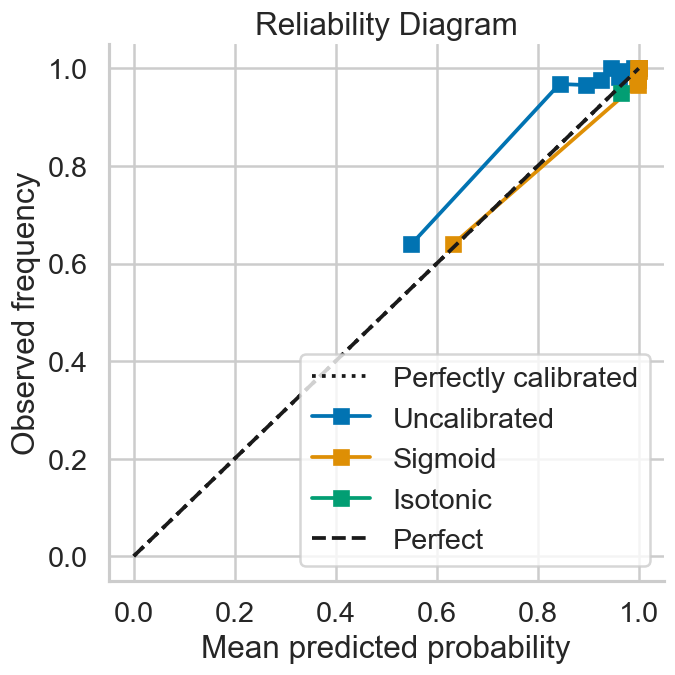

Brier scores:
  Uncalibrated: 0.030
      Sigmoid: 0.026
     Isotonic: 0.025



/var/folders/8z/vgl7z7cj5dl4m8w2mt85hhyh0000gn/T/ipykernel_5328/3239070952.py:149: RuntimeWarning: divide by zero encountered in scalar divide
  return (TP/N) - (FP/N) * (thresh/(1-thresh))
/var/folders/8z/vgl7z7cj5dl4m8w2mt85hhyh0000gn/T/ipykernel_5328/3239070952.py:149: RuntimeWarning: invalid value encountered in scalar multiply
  return (TP/N) - (FP/N) * (thresh/(1-thresh))
/var/folders/8z/vgl7z7cj5dl4m8w2mt85hhyh0000gn/T/ipykernel_5328/3239070952.py:162: RuntimeWarning: divide by zero encountered in scalar divide
  nb_all  = [ p_mean - (1-p_mean)*(t/(1-t)) for t in thresholds ]


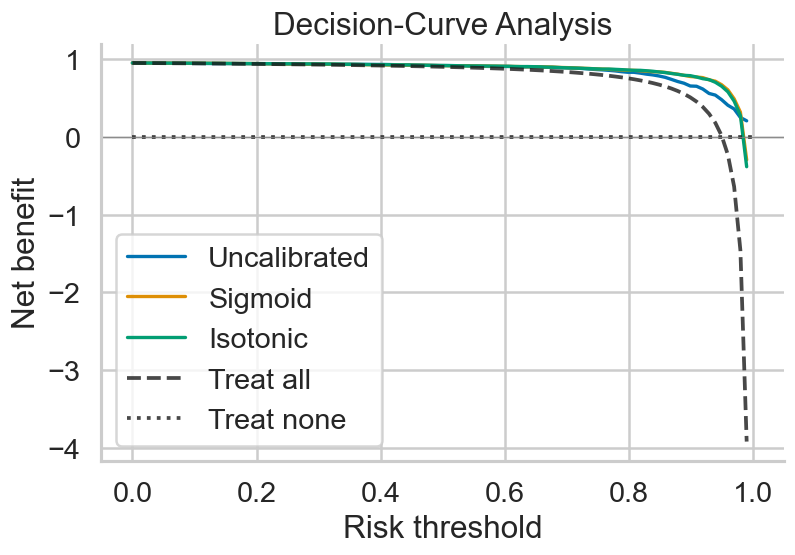


Net benefit at key thresholds:
threshold      0.05   0.10   0.20   0.25   0.30   0.35   0.40   0.50   0.60  \
treat_all     0.948  0.945  0.938  0.934  0.929  0.924  0.917  0.901  0.876   
treat_none    0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
Uncalibrated  0.948  0.945  0.941  0.938  0.935  0.933  0.931  0.916  0.905   
Sigmoid       0.949  0.947  0.942  0.938  0.935  0.931  0.927  0.916  0.907   
Isotonic      0.949  0.947  0.943  0.940  0.938  0.933  0.929  0.918  0.907   

threshold      0.70   0.80   0.90  
treat_all     0.834  0.752  0.503  
treat_none    0.000  0.000  0.000  
Uncalibrated  0.888  0.830  0.653  
Sigmoid       0.891  0.855  0.775  
Isotonic      0.888  0.859  0.785  

Top 15 pruned-feature importances:
  max_cvp                        0.0451
  auc_art_dbp                    0.0442
  min_pap_mbp                    0.0377
  auc_spo2                       0.0371
  std_cvp                        0.0275
  auc_bt                         0.0253
 

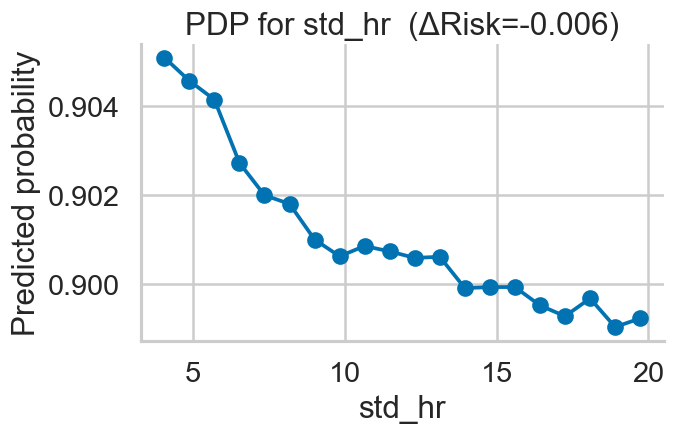

 • std_bt: ΔRisk from 0.14 → 5.61 = -0.000


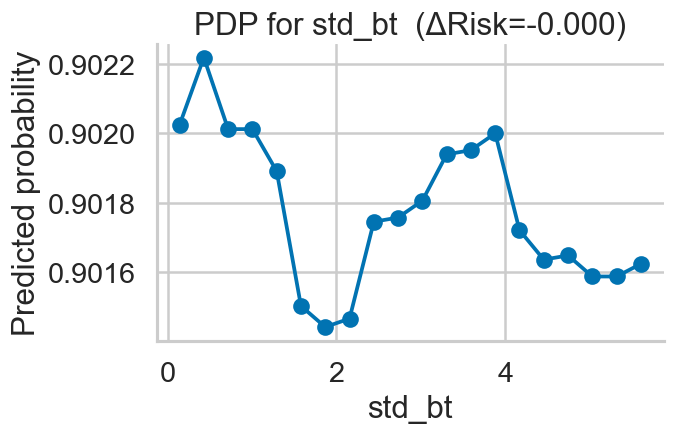

 • duration_min_eph: ΔRisk from 0.00 → 145.00 = -0.002


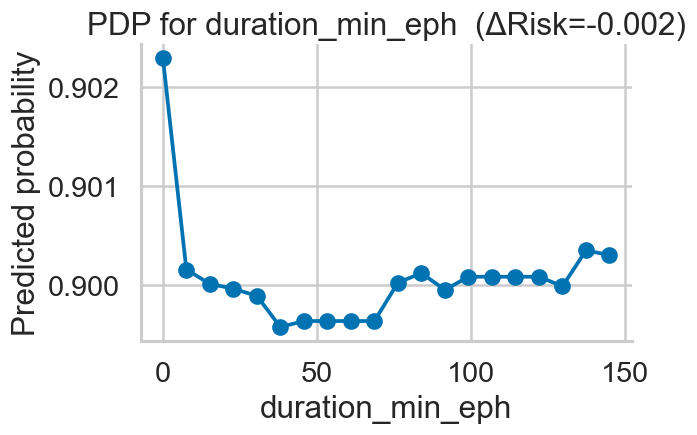

 • mean_spo2: ΔRisk from 96.26 → 99.97 = -0.001


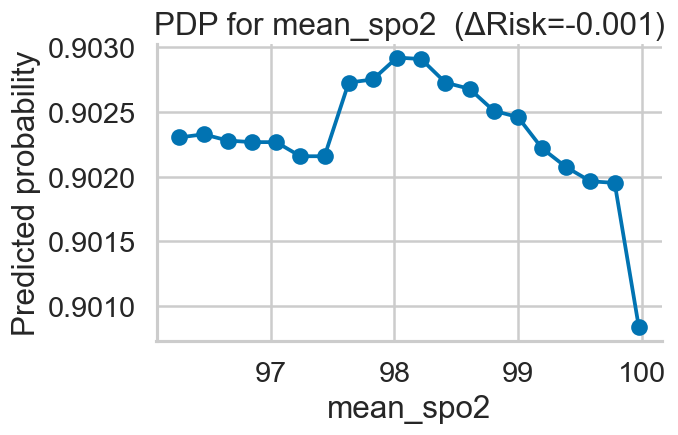

 • avg_rate_eph: ΔRisk from 0.00 → 10.00 = -0.001


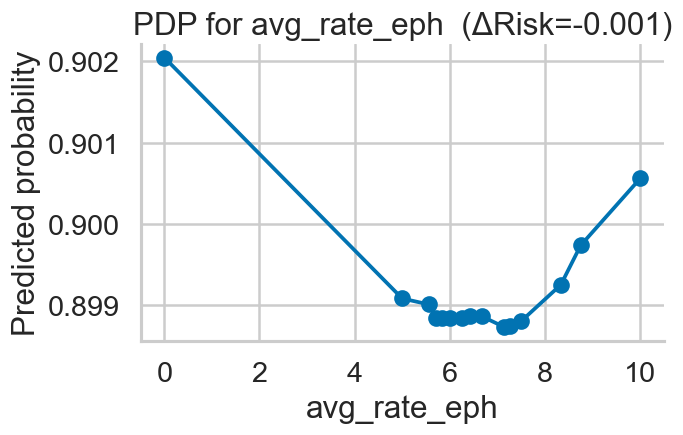

[export] Reliability points -> exports/reliability_points.csv
[export] Net benefit curves -> exports/net_benefit_points.csv
[export] Net benefit per-100 summary -> exports/net_benefit_summary_per100.csv
[export] PDP -> exports/pdp/pdp_std_hr.csv
[export] PDP -> exports/pdp/pdp_std_bt.csv
[export] PDP -> exports/pdp/pdp_duration_min_eph.csv
[export] PDP -> exports/pdp/pdp_mean_spo2.csv
[export] PDP -> exports/pdp/pdp_avg_rate_eph.csv
[export] PDP (combined) -> exports/pdp/pdp_all.csv


In [ ]:
# Supervised prediction of ICU-Long-Admit (>3 days) via RandomForest 

# (leakage drop + missingness drop + SMOTE + collinearity pruning)
# RandomForest prediction model, net-benefit analysis, permutation importance + GINI importances for interpretability

# 1) Compute true missingness from dynamic features (pre-imputation)
dyn = pd.read_csv('dynamic_features_vitals.csv')
missing_pct = dyn.isna().mean()

# 2) Load final clustered dataset for modeling (but NOT included in the prediction to prevent information leakage)
df = pd.read_csv('model_combined_dataset_clustered.csv')

# 3) Define numeric features in clustered data
numeric_feats = df.select_dtypes(include=[np.number]).columns.tolist()
print(len(numeric_feats))

# 4) Select features with ≤drop_frac% missing in dyn or protected prefixes
protected_prefixes = ['avg_rate_', 'duration_', 'num_events_', 'total_dose_', '_lag', '_slope', '_ri']
keep_feats = [
    f for f in numeric_feats
    if (missing_pct.get(f, 0) <= drop_frac) or any(f.startswith(pref) for pref in protected_prefixes)
]
print(len(keep_feats))

# 5) Extract target (ICU long stay admit) and drop leakage columns
y = df['icu_admit'].astype(int)
leak_cols = [
    'subject_id','op_id','icu_admit','icu_los_min','icuin_time','icuout_time',
    'cluster','died_inhospital','allcause_death_time','inhosp_death_time', 'asa', 'sex_num', 'age'
]
feature_pool = [f for f in keep_feats if f not in leak_cols]
print(len(feature_pool))

# 6) Build feature matrix and zero‐impute
X_full = df[feature_pool].fillna(0)

# 7) Prune collinear features (|r| > prune_frac)
corr = X_full.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > prune_frac)]
print(f"Dropping {len(to_drop)} highly‐correlated features:\n{to_drop}\n")
feature_cols = [f for f in feature_pool if f not in to_drop]
X = X_full[feature_cols]

# 8) Train/test split
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 9) SMOTE on training set
X_tr_sm, y_tr_sm = SMOTE(random_state=42).fit_resample(X_tr, y_tr)

# 10) Train Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_tr_sm, y_tr_sm)

# 11) Predict & evaluate
y_pred = clf.predict(X_te)
y_proba = clf.predict_proba(X_te)[:, 1]

print("Model Performance:")
print(f"Accuracy       : {accuracy_score(y_te, y_pred):.3f}")
print(f"Balanced Acc.  : {balanced_accuracy_score(y_te, y_pred):.3f}")
print(f"Sensitivity    : {recall_score(y_te, y_pred, pos_label=1):.3f}")
print(f"Specificity    : {recall_score(y_te, y_pred, pos_label=0):.3f}")
print(f"Precision      : {precision_score(y_te, y_pred, pos_label=1):.3f}")
print(f"ROC AUC        : {roc_auc_score(y_te, y_proba):.3f}")
print(f"Cohen’s κ      : {cohen_kappa_score(y_te, y_pred):.3f}")
print(f"Adj. Rand      : {adjusted_rand_score(y_te, y_pred):.3f}")
print(f"NMI            : {normalized_mutual_info_score(y_te, y_pred):.3f}")



# ==== Decision-Calibration Analysis ===== #

# 1) Fit post-hoc calibrators
calibrators = {
    "Uncalibrated": None,
    "Sigmoid": CalibratedClassifierCV(estimator=clf, method="sigmoid",  cv="prefit"),
    "Isotonic":  CalibratedClassifierCV(estimator=clf, method="isotonic", cv="prefit")
}

probas = {"Uncalibrated": y_proba}
for name, calib in calibrators.items():
    if name == "Uncalibrated":
        continue
    calib.fit(X_tr_sm, y_tr_sm)
    probas[name] = calib.predict_proba(X_te)[:,1]

# 2) Reliability diagram
plt.figure(figsize=(6,6))
ax = plt.gca()

for name, p in probas.items():
    disp = CalibrationDisplay.from_predictions(
        y_true=y_te,
        y_prob=p,
        n_bins=10,
        strategy="quantile",
        name=name,
        ax=ax
    )
# perfect calibration line
ax.plot([0,1], [0,1], "k--", label="Perfect")
ax.set_title("Reliability Diagram")
ax.set_xlabel("Mean predicted probability")
ax.set_ylabel("Observed frequency")
ax.legend(loc="best")
plt.tight_layout()
plt.show()

# Print Brier scores
print("Brier scores:")
for name, p in probas.items():
    print(f"  {name:>11s}: {brier_score_loss(y_te, p):.3f}")
print()

# 3) Decision-Curve Analysis
def net_benefit(y_true, y_prob, thresh):
    N    = len(y_true)
    pred = (y_prob >= thresh).astype(int)
    TP   = np.logical_and(pred==1, y_true==1).sum()
    FP   = np.logical_and(pred==1, y_true==0).sum()
    return (TP/N) - (FP/N) * (thresh/(1-thresh))

# build threshold grid over the actual prob range
all_probs  = np.concatenate(list(probas.values()))
thresholds = np.linspace(all_probs.min(), all_probs.max(), 100)

plt.figure(figsize=(7,5))
for name, p in probas.items():
    nb = [net_benefit(y_te, p, t) for t in thresholds]
    plt.plot(thresholds, nb, lw=2, label=name)

# baseline curves
p_mean = y_te.mean()
nb_all  = [ p_mean - (1-p_mean)*(t/(1-t)) for t in thresholds ]
nb_none = [ 0                          for _ in thresholds ]
plt.plot(thresholds, nb_all,  'k--', label="Treat all",  alpha=0.8)
plt.plot(thresholds, nb_none,'k:',  label="Treat none", alpha=0.8)

plt.axhline(0, color='gray', lw=0.5)
plt.xlabel("Risk threshold")
plt.ylabel("Net benefit")
plt.title("Decision-Curve Analysis")
plt.legend(loc="best")
plt.tight_layout()
plt.show()


# === Net‐Benefit Table at Selected Thresholds === # 

# choose clinically relevant thresholds
thresholds = [0.05, 0.10, 0.20, 0.25, 0.30, 0.35, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90]

# reuse `probas` dict from the calibration block:
#   probas = {"Uncalibrated": y_proba, "Sigmoid": y_sigmoid, "Isotonic": y_isotonic}

def net_benefit(y_true, y_prob, t):
    N   = len(y_true)
    pred = (y_prob >= t).astype(int)
    TP  = np.logical_and(pred==1, y_true==1).sum()
    FP  = np.logical_and(pred==1, y_true==0).sum()
    return (TP/N) - (FP/N)*(t/(1-t))

rows = []
p_mean = y_te.mean()
for t in thresholds:
    row = {"threshold": t,
           "treat_all": p_mean - (1-p_mean)*(t/(1-t)),
           "treat_none": 0.0}
    for name, p in probas.items():
        row[name] = net_benefit(y_te, p, t)
    rows.append(row)

df_nb = pd.DataFrame(rows).set_index("threshold").T
print("\nNet benefit at key thresholds:")
print(df_nb.round(3))
print()



# ==== Interpretability analysis using GINI features and permutation importances ==== # 

# 1) Top-15 Gini feature importances (pruned)
importances = pd.Series(clf.feature_importances_, index=feature_cols)
top15 = importances.sort_values(ascending=False).head(15)
print("Top 15 pruned-feature importances:")
for feat, imp in top15.items():
    print(f"  {feat:<30} {imp:.4f}")
print()

# 2) Permutation importances (alpha < 0.05)
perm = permutation_importance(
    clf, X_te, y_te,
    n_repeats=200, random_state=42, n_jobs=-1
)
pi = pd.DataFrame({
    'mean_imp': perm.importances_mean,
    'std_imp':  perm.importances_std
}, index=feature_cols)
pi['p_val']       = [np.mean(vals <= 0.0) for vals in perm.importances]
pi['significant'] = pi['p_val'] < 0.05

print("\nFeatures with approximate p < 0.05:")
print(pi[pi['significant']])
print()

top_perm = pi.sort_values('mean_imp', ascending=False).head(15)
print("Top 15 permutation importances with approximate p-values:")
print(top_perm[['mean_imp','std_imp','p_val','significant']])
print()


# === Partial Dependence Curves on the Significant Features from Interpretability === # 

# wrap test set in a DataFrame so we can index by column name
X_test_df = pd.DataFrame(X_te, columns=feature_cols)

# pick only the statistically significant permutation‐importance features
sig_feats_df = pi[pi['significant']].sort_values('mean_imp', ascending=False)
sig_feats    = sig_feats_df.index.tolist()

print("PDPs for statistically significant features:\n")
for feat in sig_feats:
    if feat not in X_test_df.columns:
        continue

    # compute the partial dependence
    pdp_res = partial_dependence(
        estimator       = clf,
        X               = X_test_df,
        features        = [feat],
        kind            = "average",
        grid_resolution = 20,
        percentiles=(0.05, 0.95)
    )

    # grab the grid & avg effect
    if 'values' in pdp_res:
        grid = pdp_res['values'][0]
    elif 'grid_values' in pdp_res:
        grid = pdp_res['grid_values'][0]
    else:
        raise KeyError(f"No grid found in PDP result for {feat}")

    avg = pdp_res['average'][0]

    # compute Δ-risk
    delta = avg[-1] - avg[0]
    print(f" • {feat}: ΔRisk from {grid[0]:.2f} → {grid[-1]:.2f} = {delta:.3f}")

    # plot
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(grid, avg, marker='o')
    ax.set_title   (f"PDP for {feat}  (ΔRisk={delta:.3f})")
    ax.set_xlabel  (feat)
    ax.set_ylabel  ("Predicted probability")
    plt.tight_layout()
    plt.show()


# ==== Export Data for External Visualization ==== # 
os.makedirs("exports/pdp", exist_ok=True)

# === EXPORT === # 

#  A) Reliability per model (Uncalibrated/Sigmoid/Isotonic in `probas`)
export_reliability_points(y_true=y_te, probas_dict=probas, n_bins=10,
                          out_csv="exports/reliability_points.csv")

#  B) Net benefit curves + per-100 summary at key thresholds
export_net_benefit_points(y_true=y_te, probas_dict=probas,
                          curve_csv="exports/net_benefit_points.csv",
                          summary_csv="exports/net_benefit_summary_per100.csv",
                          key_thresholds=(0.05,0.10,0.20,0.25,0.30))

#  C) PDP averages for significant features
X_test_df = pd.DataFrame(X_te, columns=feature_cols)
sig_feats = pi[pi['significant']].sort_values('mean_imp', ascending=False).index.tolist()
# Fallback if none marked significant:
if len(sig_feats) == 0:
    sig_feats = pd.Series(clf.feature_importances_, index=feature_cols).nlargest(10).index.tolist()

export_pdp_points(estimator=clf, X_test_df=X_test_df, features=sig_feats,
                  grid_resolution=20, percentiles=(0.05,0.95),
                  out_dir="exports/pdp", combined_csv="exports/pdp/pdp_all.csv")



In [ ]:
# Dobutamine Analysis 

df = pd.read_csv(
    "patient_timeline_events_labeled.csv",
    usecols=["op_id", "metric", "value"],
    dtype={"op_id": str, "metric": str, "value": str},
)

print("\nDistinct metric values (lowercased) from this file:")
print(df["metric"].str.strip().str.lower().unique()[:30])
df["metric_lc"] = df["metric"].str.strip().str.lower()

mask = df["metric_lc"].str.contains("dobui", na=False)
dobu = df.loc[mask, ["op_id", "value"]].copy()
dobu["rate"] = pd.to_numeric(dobu["value"], errors="coerce")
dobu = dobu.dropna(subset=["rate"])
dobu = dobu.loc[dobu["rate"] > 0].copy()

per_case = (
    dobu
    .groupby("op_id")
    .agg(
        total_minutes=("rate", lambda s: len(s) * 5),
        mean_rate    =("rate", "mean"),
        median_rate  =("rate", "median"),
    )
    .reset_index()
)

if per_case.empty:
    print("\nNo rows matched that dobutamine substring. Check that 'substring_to_match' is correct.\n")
else:
    print("\nPer‐case dobutamine infusion summary (first 10 rows):")
    print(per_case.head(10).to_string(index=False))

    avg_rate_all = per_case["mean_rate"].median()
    med_rate_all = per_case["median_rate"].mean()
    avg_time_all = per_case["total_minutes"].median()

    print("\n=== Aggregate across all cases that received any dobutamine: ===")
    print(f"Average of mean nonzero dobutamine rates  : {avg_rate_all:.2f}")
    print(f"Average of median nonzero dobutamine rates: {med_rate_all:.2f}")
    print(f"Average total dobutamine infusion time   : {avg_time_all:.1f} minutes")



Distinct metric values (lowercased) from this file:
['hb' 'hct' 'wbc' 'platelet' 'seg' 'lymphocyte' 'sodium' 'potassium'
 'chloride' 'bun' 'creatinine' 'total_bilirubin' 'ast' 'alt' 'calcium'
 'phosphorus' 'total_protein' 'albumin' 'alp' 'crp' 'aptt' 'ptinr'
 'fibrinogen' 'ck' 'ckmb' 'troponin_i' 'admission_time' 'nicorandil'
 'losartan potassium' 'perindopril t-butylamine']

Per‐case dobutamine infusion summary (first 10 rows):
    op_id  total_minutes  mean_rate  median_rate
400045748             15   3.333333         2.50
400168088             10   8.750000         8.75
400243488              5   2.500000         2.50
400305595             20   5.000000         5.00
400327704             70   3.000000         3.00
400499168             20   3.750000         3.75
400542528             10   3.750000         3.75
400579436              5   5.000000         5.00
400630807             10   6.250000         6.25
400632855              5   3.000000         3.00

=== Aggregate across all c